# 1.IMPORT CÁC THƯ VIỆN CẦN SỬ DỤNG

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import warnings
import re
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import auc,f1_score,accuracy_score,recall_score,precision_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
import gseapy
import pickle
import utils

In [2]:
warnings.filterwarnings('ignore')

# 2.ĐỌC FILE DỮ LIỆU

## 2.1.GSE91061 DATASET

**GHI CHÚ:** Đọc các file dữ liệu đã xử lý của GSE91061:
+ meta_GSE91061.csv: Cung cấp thông tin Treatment response của mỗi mẫu
+ RNA_seq_GSE91061.csv: Cung cấp kết quả gốc của RNA-seq của mỗi mẫu
+ RNA_seq_normalized_GSE91061.csv: Cung cấp kết quả đã chuẩn hóa RNA-seq của mỗi mẫu

In [3]:
# ĐỌC FILE  RNA_seq_GSE91061.csv
df_gse91061=pd.read_csv('Preprocessed_data/GSE91061/RNA_seq_GSE91061.csv',index_col=0)
df_gse91061.sort_index(ascending=True,inplace=True)
df_gse91061.head(4)

,1,10,100,1000,10000,100009676,10001,10002,10003,100033413,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
Pt101_On_AD681975-5,251,6,2041,536,3154,168,1250,3,99,0,...,14294,4768,2293,2372,5906,12463,6,3808,2789,3
Pt101_Pre_AD486328-5,279,0,1630,228,2485,74,1189,0,19,0,...,11047,3744,1884,1369,4604,9871,9,3233,2398,12
Pt103_On_AE134059-6,661,0,136,3,5644,99,509,6,50,4,...,11614,4531,4078,12676,666,3939,8,7243,838,4
Pt103_Pre_AE134058-2,1124,0,1069,23,1337,129,484,0,87,0,...,4846,915,1828,1220,396,1854,0,1706,242,29


In [4]:
# ĐỌC FILE meta_GSE91061.csv
df_meta_GSE91061=pd.read_csv('Preprocessed_data/GSE91061/meta_GSE91061.csv',index_col=0)
df_meta_GSE91061.sort_index(ascending=True,inplace=True)
df_meta_GSE91061.head(4)

,conditions,New_conditions,New_conditions_encoded
Pt101_On_AD681975-5,PRCR,Non-responders,0
Pt101_Pre_AD486328-5,PRCR,Non-responders,0
Pt103_On_AE134059-6,PD,Responder,1
Pt103_Pre_AE134058-2,PD,Responder,1


In [5]:
# ĐỌC FILE  RNA_seq_normalized_GSE91061.csv
df_gse91061_normalized=pd.read_csv('Preprocessed_data/GSE91061/RNA_seq_normalized_GSE91061.csv',index_col=0)
df_gse91061_normalized.sort_index(ascending=True,inplace=True)
df_gse91061_normalized.head(4)

,1,10,100,1000,10000,100009676,10001,10002,10003,100033413,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
Pt101_On_AD681975-5,8.949981,4.827091,10.285729,8.629851,11.380731,6.959239,9.786885,1.412873,6.115981,-0.124352,...,13.313909,11.654828,10.847703,10.730247,11.780809,13.004016,7.321257,11.440785,10.831259,1.494326
Pt101_Pre_AD486328-5,9.023143,4.745642,10.226275,7.846224,11.308811,6.260483,9.933494,1.046816,4.599709,-0.123137,...,13.216594,11.575805,10.823513,10.289919,11.691309,12.934810,7.332657,11.454690,10.860502,2.236711
Pt103_On_AE134059-6,9.573336,4.746327,7.570974,4.094638,12.478290,6.771449,9.165081,1.835590,5.765165,0.470071,...,13.493062,12.023260,11.946048,13.206384,9.617467,12.062423,7.334513,12.632570,9.835034,1.737704
Pt103_Pre_AE134058-2,10.779296,4.748063,10.364105,5.963120,11.213758,7.460724,9.510031,1.058574,6.762114,-0.117971,...,12.878172,10.551562,11.413766,10.785883,9.427273,11.597399,7.307512,11.333647,8.826404,3.279596


## 2.2.GSE78220 DATASET

**GHI CHÚ:** Đọc các file dữ liệu đã xử lý của GSE78220:
+ meta_GSE78220.csv: Cung cấp thông tin Treatment response của mỗi mẫu
+ RNA_seq_normalized_GSE78220.csv: Cung cấp kết quả đã chuẩn hóa RNA-seq của mỗi mẫu

In [6]:
# ĐỌC FILE  RNA_seq_normalized_GSE78220.csv
df_gse78220_normalized=pd.read_csv('Preprocessed_data/GSE78220/RNA_seq_normalized_GSE78220.csv',index_col=0)
df_gse78220_normalized.head(4)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Pt1.baseline,8.025380,0.677503,0.0,185.3040,0.363531,0.014134,0.068722,0.000000,6.557490,0.024924,...,4.517615,9.838935,1.694975,3.152445,7.699230,0.007498,7.302015,61.04475,3.463620,14.703500
Pt10.baseline,4.346750,1.914350,0.0,501.6970,1.489845,0.030801,0.056148,0.178040,26.199650,0.025032,...,7.060635,18.511250,1.000603,1.562540,8.046115,0.022734,5.457640,71.65415,3.896335,7.293775
Pt12.baseline,6.508715,4.797930,0.0,530.2375,1.868520,0.007370,0.018405,0.059667,2.187715,0.248870,...,24.105250,38.137750,0.407459,1.856880,4.742560,0.010006,3.121325,379.13500,3.783140,11.620600
Pt13.baseline,7.291400,0.410501,0.0,661.1375,1.018770,0.000000,0.028570,0.123011,8.535705,0.333757,...,5.435285,9.498985,1.273735,2.208765,7.082685,0.016109,9.690965,96.66915,4.494465,10.071900


In [7]:
# ĐỌC FILE meta_GSE91061.csv
df_meta_GSE78220=pd.read_csv('Preprocessed_data/GSE78220/meta_GSE78220.csv',index_col=0)
df_meta_GSE78220.head(4)

,conditions,New_conditions,New_conditions_encoded
Pt1,Progressive Disease,Non-responders,0
Pt10,Progressive Disease,Non-responders,0
Pt12,Progressive Disease,Non-responders,0
Pt13,Complete Response,Responder,1


# 3.PHÂN TÍCH BIỂU HIỆN GENE (DEA)

**GHI CHÚ:** Sử dụng bộ dataset GSE91061 và thuật toán Deseq2 để chọn ra những gene upregulated và downregulated giữa 2 mẫu responders và non-responders

## 3.1.XÁC ĐỊNH UP-REGULATED GENES VÀ DOWN-REGULATED GENES

In [6]:
# KHỞI TẠO ĐỐI TƯỢNG
dds=DeseqDataSet(counts=df_gse91061,metadata=df_meta_GSE91061,design_factors='New_conditions')

In [7]:
dds.deseq2()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.40 seconds.

Fitting dispersions...
... done in 32.13 seconds.

Fitting dispersion trend curve...
... done in 2.02 seconds.

Fitting MAP dispersions...
... done in 34.13 seconds.

Fitting LFCs...
... done in 17.88 seconds.

Calculating cook's distance...
... done in 0.55 seconds.

Replacing 3956 outlier genes.

Fitting dispersions...
... done in 5.26 seconds.

Fitting MAP dispersions...
... done in 5.69 seconds.

Fitting LFCs...
... done in 4.51 seconds.



#### 3.1.1.TH1: INDEPENDENT_FILTER: FALSE

In [14]:
result_DEA=DeseqStats(dds,
                      n_cpus=8,
                      contrast=['New_conditions','Responder','Non-responders'],
                      cooks_filter=True,
                      independent_filter=False)

In [15]:
result_DEA.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: New_conditions Responder vs Non-responders
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
1       361.239663       -0.769654  0.298530 -2.578145  0.009933  0.080527
10        3.887258        1.514931  0.865938  1.749467  0.080210  0.293357
100     709.249000       -0.303335  0.230713 -1.314768  0.188588  0.480329
1000   1201.511071       -0.631240  0.424059 -1.488568  0.136601  0.398098
10000  5709.043563        0.126122  0.197119  0.639824  0.522287  0.812709
...            ...             ...       ...       ...       ...       ...
9991   5738.384462       -0.112636  0.162543 -0.692964  0.488332  0.786775
9992     24.994762       -0.031439  0.253186 -0.124173  0.901178  0.999108
9993   2949.014719        0.159976  0.106326  1.504583  0.132431  0.391116
9994   1163.328307       -0.197323  0.113653 -1.736183  0.082531  0.297784
9997      4.190513       -0.441766  0.413413 -1.068583  0.285258  0.601268

[22187 rows x 6 co

... done in 4.65 seconds.



In [16]:
df_result_DEA=result_DEA.results_df
df_result_DEA

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,361.239663,-0.769654,0.298530,-2.578145,0.009933,0.080527
10,3.887258,1.514931,0.865938,1.749467,0.080210,0.293357
100,709.249000,-0.303335,0.230713,-1.314768,0.188588,0.480329
1000,1201.511071,-0.631240,0.424059,-1.488568,0.136601,0.398098
10000,5709.043563,0.126122,0.197119,0.639824,0.522287,0.812709
...,...,...,...,...,...,...
9991,5738.384462,-0.112636,0.162543,-0.692964,0.488332,0.786775
9992,24.994762,-0.031439,0.253186,-0.124173,0.901178,0.999108
9993,2949.014719,0.159976,0.106326,1.504583,0.132431,0.391116
9994,1163.328307,-0.197323,0.113653,-1.736183,0.082531,0.297784


In [17]:
for threshold in np.linspace(0,1.5,50):
    # LỰA CHỌN 'UPREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC > 0.5
    df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>threshold)&(df_result_DEA['padj']<0.05)]
    # LIST CÁC 'UPREGULATED GENE'
    list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
    # LỰA CHỌN 'DOWNREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC < -0.5
    df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-threshold)&(df_result_DEA['padj']<0.05)]
    list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
    print(f'threshold: {threshold} up:{len(list_upregulated_genes_id)} and down:{len(list_downregulated_genes_id)}, sum:{len(list_upregulated_genes_id)+len(list_downregulated_genes_id)}')

threshold: 0.0 up:1046 and down:1122, sum:2168
threshold: 0.030612244897959183 up:1046 and down:1122, sum:2168
threshold: 0.061224489795918366 up:1046 and down:1122, sum:2168
threshold: 0.09183673469387754 up:1046 and down:1122, sum:2168
threshold: 0.12244897959183673 up:1046 and down:1122, sum:2168
threshold: 0.15306122448979592 up:1046 and down:1122, sum:2168
threshold: 0.18367346938775508 up:1046 and down:1122, sum:2168
threshold: 0.21428571428571427 up:1045 and down:1122, sum:2167
threshold: 0.24489795918367346 up:1041 and down:1120, sum:2161
threshold: 0.2755102040816326 up:1039 and down:1114, sum:2153
threshold: 0.30612244897959184 up:1035 and down:1107, sum:2142
threshold: 0.336734693877551 up:1019 and down:1102, sum:2121
threshold: 0.36734693877551017 up:990 and down:1084, sum:2074
threshold: 0.3979591836734694 up:968 and down:1065, sum:2033
threshold: 0.42857142857142855 up:939 and down:1047, sum:1986
threshold: 0.45918367346938777 up:916 and down:1031, sum:1947
threshold: 0.4

In [18]:
# LỰA CHỌN 'UPREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC > 0.5
df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>np.sqrt(2))&(df_result_DEA['padj']<0.05)]
# LIST CÁC 'UPREGULATED GENE'
list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_upregulated_genes_id)} genes quá biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 534 genes quá biểu hiện giữa 2 mẫu responders và non-responders


In [19]:
# LỰA CHỌN 'DOWNREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC < -0.5
df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-np.sqrt(2))&(df_result_DEA['padj']<0.05)]
list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_downregulated_genes_id)} genes giảm biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 369 genes giảm biểu hiện giữa 2 mẫu responders và non-responders


#### 3.1.2.TH2: INDEPENDENT_FILTER: TRUE

In [47]:
result_DEA=DeseqStats(dds,
                      n_cpus=8,
                      contrast=['New_conditions','Responder','Non-responders'],
                      cooks_filter=True,
                      independent_filter=True)

In [48]:
result_DEA.summary()

Running Wald tests...
... done in 16.58 seconds.



Log2 fold change & Wald test p-value: New_conditions Responder vs Non-responders
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
1       361.239663       -0.769654  0.298530 -2.578145  0.009933  0.071235
10        3.887258        1.514931  0.865938  1.749467  0.080210  0.260168
100     709.249000       -0.303335  0.230713 -1.314768  0.188588  0.428428
1000   1201.511071       -0.631240  0.424059 -1.488568  0.136601  0.354059
10000  5709.043563        0.126122  0.197119  0.639824  0.522287  0.740824
...            ...             ...       ...       ...       ...       ...
9991   5738.384462       -0.112636  0.162543 -0.692964  0.488332  0.715624
9992     24.994762       -0.031439  0.253186 -0.124173  0.901178  0.957001
9993   2949.014719        0.159976  0.106326  1.504583  0.132431  0.347692
9994   1163.328307       -0.197323  0.113653 -1.736183  0.082531  0.264167
9997      4.190513       -0.441766  0.413413 -1.068583  0.285258  0.540142

[22187 rows x 6 co

In [49]:
df_result_DEA=result_DEA.results_df
df_result_DEA

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,361.239663,-0.769654,0.298530,-2.578145,0.009933,0.071235
10,3.887258,1.514931,0.865938,1.749467,0.080210,0.260168
100,709.249000,-0.303335,0.230713,-1.314768,0.188588,0.428428
1000,1201.511071,-0.631240,0.424059,-1.488568,0.136601,0.354059
10000,5709.043563,0.126122,0.197119,0.639824,0.522287,0.740824
...,...,...,...,...,...,...
9991,5738.384462,-0.112636,0.162543,-0.692964,0.488332,0.715624
9992,24.994762,-0.031439,0.253186,-0.124173,0.901178,0.957001
9993,2949.014719,0.159976,0.106326,1.504583,0.132431,0.347692
9994,1163.328307,-0.197323,0.113653,-1.736183,0.082531,0.264167


In [50]:
for threshold in np.linspace(0,2,50):
    # LỰA CHỌN 'UPREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC > 0.5
    df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>threshold)&(df_result_DEA['padj']<0.05)]
    # LIST CÁC 'UPREGULATED GENE'
    list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
    # LỰA CHỌN 'DOWNREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC < -0.5
    df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-threshold)&(df_result_DEA['padj']<0.05)]
    list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
    print(f'threshold: {threshold} up:{len(list_upregulated_genes_id)} and down:{len(list_downregulated_genes_id)}, sum:{len(list_upregulated_genes_id)+len(list_downregulated_genes_id)}')

threshold: 0.0 up:1118 and down:1199, sum:2317
threshold: 0.04081632653061224 up:1118 and down:1199, sum:2317
threshold: 0.08163265306122448 up:1118 and down:1199, sum:2317
threshold: 0.12244897959183673 up:1118 and down:1199, sum:2317
threshold: 0.16326530612244897 up:1118 and down:1199, sum:2317
threshold: 0.2040816326530612 up:1118 and down:1199, sum:2317
threshold: 0.24489795918367346 up:1113 and down:1196, sum:2309
threshold: 0.2857142857142857 up:1109 and down:1185, sum:2294
threshold: 0.32653061224489793 up:1093 and down:1175, sum:2268
threshold: 0.36734693877551017 up:1051 and down:1150, sum:2201
threshold: 0.4081632653061224 up:1018 and down:1121, sum:2139
threshold: 0.44897959183673464 up:977 and down:1101, sum:2078
threshold: 0.4897959183673469 up:933 and down:1074, sum:2007
threshold: 0.5306122448979591 up:904 and down:1048, sum:1952
threshold: 0.5714285714285714 up:879 and down:1023, sum:1902
threshold: 0.6122448979591836 up:859 and down:1000, sum:1859
threshold: 0.6530612

In [51]:
# LỰA CHỌN 'UPREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC > 0.5
df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>np.sqrt(2))&(df_result_DEA['padj']<0.05)]
# LIST CÁC 'UPREGULATED GENE'
list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_upregulated_genes_id)} genes quá biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 553 genes quá biểu hiện giữa 2 mẫu responders và non-responders


In [52]:
# LỰA CHỌN 'DOWNREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC < -0.5
df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-np.sqrt(2))&(df_result_DEA['padj']<0.05)]
list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_downregulated_genes_id)} genes giảm biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 375 genes giảm biểu hiện giữa 2 mẫu responders và non-responders


## 3.2.lƯU KẾT QUẢ

In [53]:
# LƯU KẾT QUẢ
df_result_DEA.to_csv('DEA results/DEA_result.csv')

## 3.3.KẾT QUẢ

In [54]:
df_result_DEA=pd.read_csv('DEA results/DEA_result.csv',index_col=0)
df_result_DEA

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,361.239663,-0.769654,0.298530,-2.578145,0.009933,0.071235
10,3.887258,1.514931,0.865938,1.749467,0.080210,0.260168
100,709.249000,-0.303335,0.230713,-1.314768,0.188588,0.428428
1000,1201.511071,-0.631240,0.424059,-1.488568,0.136601,0.354059
10000,5709.043563,0.126122,0.197119,0.639824,0.522287,0.740824
...,...,...,...,...,...,...
9991,5738.384462,-0.112636,0.162543,-0.692964,0.488332,0.715624
9992,24.994762,-0.031439,0.253186,-0.124173,0.901178,0.957001
9993,2949.014719,0.159976,0.106326,1.504583,0.132431,0.347692
9994,1163.328307,-0.197323,0.113653,-1.736183,0.082531,0.264167


In [55]:
# LỰA CHỌN 'UPREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC > 0.5
df_upregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']>np.sqrt(2))&(df_result_DEA['padj']<0.05)]
# LIST CÁC 'UPREGULATED GENE'
list_upregulated_genes_id=df_upregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_upregulated_genes_id)} genes quá biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 553 genes quá biểu hiện giữa 2 mẫu responders và non-responders


In [56]:
# LỰA CHỌN 'DOWNREGULATED GENE' NHỮNG MẪU CÓ p-value<0.05 và log2FC < -0.5
df_downregulated_genes_id=df_result_DEA[(df_result_DEA['log2FoldChange']<-np.sqrt(2))&(df_result_DEA['padj']<0.05)]
list_downregulated_genes_id=df_downregulated_genes_id.index.to_list()
print(f'* Tổng cộng có {len(list_downregulated_genes_id)} genes giảm biểu hiện giữa 2 mẫu responders và non-responders')

* Tổng cộng có 375 genes giảm biểu hiện giữa 2 mẫu responders và non-responders


In [57]:
list_up_down_genes_id=list_downregulated_genes_id+list_upregulated_genes_id
print(f'* Tổng cộng có {len(list_up_down_genes_id)} genes')

* Tổng cộng có 928 genes


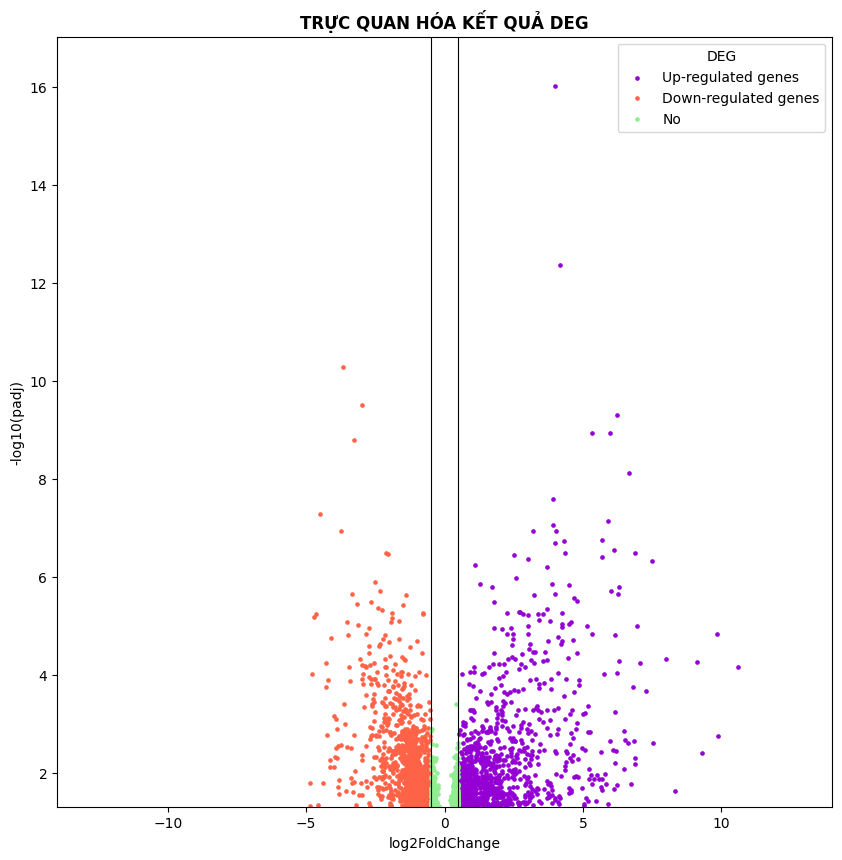

In [58]:
utils.vocanol_plot(df_result_DEA)

**KẾT LUẬN:** Mẫu gồm tổng cộng 22,187 genes thì có
+ 1066 genes quá biểu hiện
+ 1204 genes bị giảm biểu hiện

# 4.ĐÁNH GIÁ MỨC ĐỘ ĐÁP ỨNG MIỄN DỊCH

**NHẬN XÉT:** Sử dụng thuật tóa xCell để tính toán điểm số miễn dịch (immuno score), từ đó đánh giá đáp ứng miễn dịch trong khối u:
+ TH1: Vẫn giữ tất cả các gene
+ TH2: Từ kết quả DEA lựa chọn ra ra các gene có log2FC >2
+ Phân tích độ đáp ứng miễn dịch tại: [xCell](https://comphealth.ucsf.edu/app/xcell)

## 4.1.SỬ DỤNG TẤT CẢ CÁC GENE

In [13]:
# LỰA CHỌN LIST CÁC GENE
xcell_input_gene=df_gse91061_normalized.columns
# CHUYỂN 'GENE ID' THÀNH 'GENE SYMBOL'
dict_gene_xcell=utils.gene_dict_id_symbol(xcell_input_gene)
dict_gene_xcell

Input sequence provided is already in string format. No operation performed


{'1': 'A1BG',
 '10': 'NAT2',
 '100': 'ADA',
 '1000': 'CDH2',
 '10000': 'AKT3',
 '100009676': 'ZBTB11-AS1',
 '10001': 'MED6',
 '10002': 'NR2E3',
 '10003': 'NAALAD2',
 '100033413': 'SNORD116-1',
 '100033414': 'SNORD116-2',
 '100033415': 'SNORD116-3',
 '100033417': 'SNORD116-5',
 '100033420': 'SNORD116-8',
 '100033422': 'SNORD116-10',
 '100033424': 'SNORD116-12',
 '100033425': 'SNORD116-13',
 '100033427': 'SNORD116-15',
 '100033428': 'SNORD116-16',
 '100033430': 'SNORD116-18',
 '100033431': 'SNORD116-20',
 '100033434': 'SNORD116-23',
 '100033435': 'SNORD116-24',
 '100033436': 'SNORD116-25',
 '100033438': 'SNORD116-26',
 '100033450': 'SNORD115-13',
 '100033820': 'SNORD116-28',
 '100033821': 'SNORD116-29',
 '100036567': 'SNORD115-47',
 '100037417': 'DDTL',
 '100038246': 'TLX1NB',
 '10004': 'NAALADL1',
 '100048912': 'CDKN2B-AS1',
 '100049076': 'GUSBP17',
 '100049587': 'SIGLEC14',
 '10005': 'ACOT8',
 '10006': 'ABI1',
 '10007': 'GNPDA1',
 '100073347': 'MIMT1',
 '10008': 'KCNE3',
 '10009': 'ZBT

In [14]:
# MAP 'GENE ID' THANH 'GENE SYMBOL'
df_xcell=df_gse91061_normalized.rename(dict_gene_xcell,axis=1)
# TRANPOSE DATAFRAME 
df_xcell=df_xcell.T
df_xcell

,Pt101_On_AD681975-5,Pt101_Pre_AD486328-5,Pt103_On_AE134059-6,Pt103_Pre_AE134058-2,Pt105_On_AE373241-6,Pt106_On_AD513626-6,Pt106_Pre_AD502250-5,Pt108_On_AE373243-6,Pt109_On_AE527955-5,Pt109_On_AE527955-6,...,Pt90_Pre_AD467873-6,Pt92_On_AE148750-5,Pt92_Pre_AE134060-5,Pt93_On_AE070988-5,Pt94_On_AE373242-6,Pt94_Pre_AD732850-6,Pt98_On_AE086717-6,Pt98_Pre_AD733586-8,Pt9_On_E9047644-7,Pt9_Pre_E9021024-6
A1BG,8.949981,9.023143,9.573336,10.779296,8.937731,9.017880,8.993183,9.216624,8.962497,8.856814,...,9.225968,8.982577,8.821508,8.963987,19.236138,9.109138,8.988242,9.062579,8.943428,8.888400
NAT2,4.827091,4.745642,4.746327,4.748063,4.745610,4.764431,4.787472,4.789188,4.746564,4.746203,...,4.745958,4.746185,4.746287,4.745357,18.782019,4.767667,4.745901,4.746107,4.900401,4.889257
ADA,10.285729,10.226275,7.570974,10.364105,9.428236,9.128837,9.209574,8.021938,8.613264,8.418825,...,9.508228,10.045471,9.417159,7.121161,8.506825,9.163653,8.657610,7.999846,8.404268,8.369369
CDH2,8.629851,7.846224,4.094638,5.963120,6.781157,10.872252,10.779973,9.301711,6.818714,6.312657,...,8.365443,8.991763,9.050899,6.146698,10.722709,7.685573,7.371841,7.784339,11.771848,11.511405
AKT3,11.380731,11.308811,12.478290,11.213758,12.223986,12.757052,12.698945,10.102231,11.155385,11.006544,...,11.988695,12.300655,12.379334,12.654630,11.892606,12.411115,12.586189,12.431851,12.565615,12.619806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,13.004016,12.934810,12.062423,11.597399,12.126886,11.549373,11.956301,11.882997,11.603701,11.555067,...,12.141332,12.373636,12.237407,12.788176,11.781885,12.077931,12.253268,11.980258,11.777977,11.903910
KCNE2,7.321257,7.332657,7.334513,7.307512,7.555249,7.358495,7.356234,7.452315,7.412057,7.386684,...,7.322647,7.340131,7.398554,7.369626,7.386278,7.355075,7.362215,7.349178,7.353816,7.387992
DGCR2,11.440785,11.454690,12.632570,11.333647,11.608289,11.362215,11.367981,11.328718,12.197865,12.041065,...,11.101001,11.619212,12.062451,11.460147,11.656451,11.521682,11.049034,11.309542,11.391955,11.286326
CASP8AP2,10.831259,10.860502,9.835034,8.826404,10.021762,9.433446,9.917718,9.689126,9.442596,9.595776,...,9.782242,10.467633,10.264261,9.961196,9.583739,9.856848,9.465097,9.465356,9.991407,10.070162


In [35]:
# LƯU FILE
df_xcell.to_csv('Preprocessed_data/xcell_all_genes.tsv',sep='\t')

## 4.2.XỬ DỤNG GENE CÓ LOG2FC >2

In [45]:
# Lựa chọn các gene có log2FC > 2
xcell_input_gene=df_result_DEA[(df_result_DEA['log2FoldChange']>2)|(df_result_DEA['log2FoldChange']<-2)].index.to_list()
xcell_input_gene=list(map(str,xcell_input_gene))

In [47]:
# LỌC NHỮNG GENE CÓ TRONG TẬP GSE91061 ĐÃ CHUẨN HÓA
df_xcell_2=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(xcell_input_gene)]
df_xcell_2

,10,100033413,100126299,100128054,100128285,100128675,100128682,100128946,100129027,100129271,...,9635,9699,9721,9723,973,9752,9890,9965,9971,9982
Pt101_On_AD681975-5,4.827091,-0.124352,-0.972332,0.295945,2.042398,4.389733,3.091473,-0.579807,0.086599,-1.468226,...,2.105527,5.200327,3.211298,4.240549,12.900364,0.035642,7.921808,-1.047710,6.502729,6.225442
Pt101_Pre_AD486328-5,4.745642,-0.123137,-0.971820,0.365806,3.243677,6.661508,2.400284,-0.872143,0.098268,-1.335364,...,0.396923,5.646775,1.923252,5.365736,13.140544,0.038354,7.250322,-1.033192,6.499537,6.225666
Pt103_On_AE134059-6,4.746327,0.470071,-0.470765,0.441587,3.935664,4.516442,8.614415,-1.106330,0.111997,7.658405,...,9.664670,8.219506,6.051357,5.391358,5.115398,0.041640,8.772583,-0.423557,6.494790,7.203824
Pt103_Pre_AE134058-2,4.748063,-0.117971,-0.198775,2.500808,1.873939,2.395469,6.283002,-1.102580,0.143373,9.660030,...,8.104240,7.027517,6.839214,5.181088,10.754654,0.049545,7.369914,-0.938471,6.495383,7.434130
Pt105_On_AE373241-6,4.745610,0.176346,-0.971849,7.535547,4.619885,3.042411,9.072082,-1.107730,0.485948,-1.342513,...,1.659580,5.542109,-0.132513,3.372215,8.276450,0.038198,12.169791,-1.034489,6.509348,6.225653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.767667,-0.120968,-0.970217,0.473022,3.188851,1.543802,6.644080,-0.590192,0.118024,-1.140964,...,3.539868,4.683880,0.719763,2.607997,8.173577,0.043116,8.452517,-0.997841,6.758828,6.226072
Pt98_On_AE086717-6,4.745901,0.197222,-0.309787,7.869255,3.412781,4.563389,9.793192,-1.107464,1.155369,-1.280102,...,3.086088,4.667230,-0.111780,3.205372,5.780895,0.039607,5.701945,-1.023158,7.244735,6.225771
Pt98_Pre_AD733586-8,4.746107,-0.122121,-0.577891,7.854411,2.925345,3.734087,9.705544,-1.106901,1.714682,1.171905,...,3.599744,4.609013,-0.097672,5.164645,4.294059,0.040596,3.556506,-0.445474,6.970040,6.225855
Pt9_On_E9047644-7,4.900401,1.040166,-0.972245,0.969685,5.435165,3.653457,1.909787,-1.108030,0.878807,-1.443957,...,2.704836,8.012246,3.723955,4.700475,4.095173,1.303401,8.337194,-0.547868,6.494401,6.225480


In [48]:
# TẠO DICT GENE ID: GENE SYMBOL
dict_gene_xcell_2=utils.gene_dict_id_symbol(df_xcell_2.columns)

Input sequence provided is already in string format. No operation performed


In [49]:
# ĐỔI TÊN COLUMN (TỪ GENE ID SANG GENE SYMBOL)
df_xcell_2.rename(dict_gene_xcell_2,axis=1,inplace=True)
df_xcell_2

,NAT2,SNORD116-1,VTRNA2-1,PLCE1-AS1,DNM1P35,HPN-AS1,LINC01531,LINC01310,PCBP3-AS1,KPLCE,...,CLCA2,RIMS2,GPRIN2,SEMA3E,CD79A,PCDHA9,PLPPR4,FGF19,NR1H4,FGFBP1
Pt101_On_AD681975-5,4.827091,-0.124352,-0.972332,0.295945,2.042398,4.389733,3.091473,-0.579807,0.086599,-1.468226,...,2.105527,5.200327,3.211298,4.240549,12.900364,0.035642,7.921808,-1.047710,6.502729,6.225442
Pt101_Pre_AD486328-5,4.745642,-0.123137,-0.971820,0.365806,3.243677,6.661508,2.400284,-0.872143,0.098268,-1.335364,...,0.396923,5.646775,1.923252,5.365736,13.140544,0.038354,7.250322,-1.033192,6.499537,6.225666
Pt103_On_AE134059-6,4.746327,0.470071,-0.470765,0.441587,3.935664,4.516442,8.614415,-1.106330,0.111997,7.658405,...,9.664670,8.219506,6.051357,5.391358,5.115398,0.041640,8.772583,-0.423557,6.494790,7.203824
Pt103_Pre_AE134058-2,4.748063,-0.117971,-0.198775,2.500808,1.873939,2.395469,6.283002,-1.102580,0.143373,9.660030,...,8.104240,7.027517,6.839214,5.181088,10.754654,0.049545,7.369914,-0.938471,6.495383,7.434130
Pt105_On_AE373241-6,4.745610,0.176346,-0.971849,7.535547,4.619885,3.042411,9.072082,-1.107730,0.485948,-1.342513,...,1.659580,5.542109,-0.132513,3.372215,8.276450,0.038198,12.169791,-1.034489,6.509348,6.225653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.767667,-0.120968,-0.970217,0.473022,3.188851,1.543802,6.644080,-0.590192,0.118024,-1.140964,...,3.539868,4.683880,0.719763,2.607997,8.173577,0.043116,8.452517,-0.997841,6.758828,6.226072
Pt98_On_AE086717-6,4.745901,0.197222,-0.309787,7.869255,3.412781,4.563389,9.793192,-1.107464,1.155369,-1.280102,...,3.086088,4.667230,-0.111780,3.205372,5.780895,0.039607,5.701945,-1.023158,7.244735,6.225771
Pt98_Pre_AD733586-8,4.746107,-0.122121,-0.577891,7.854411,2.925345,3.734087,9.705544,-1.106901,1.714682,1.171905,...,3.599744,4.609013,-0.097672,5.164645,4.294059,0.040596,3.556506,-0.445474,6.970040,6.225855
Pt9_On_E9047644-7,4.900401,1.040166,-0.972245,0.969685,5.435165,3.653457,1.909787,-1.108030,0.878807,-1.443957,...,2.704836,8.012246,3.723955,4.700475,4.095173,1.303401,8.337194,-0.547868,6.494401,6.225480


In [50]:
# TRANPOSE DATAFRAME
df_xcell_2=df_xcell_2.T
df_xcell_2

,Pt101_On_AD681975-5,Pt101_Pre_AD486328-5,Pt103_On_AE134059-6,Pt103_Pre_AE134058-2,Pt105_On_AE373241-6,Pt106_On_AD513626-6,Pt106_Pre_AD502250-5,Pt108_On_AE373243-6,Pt109_On_AE527955-5,Pt109_On_AE527955-6,...,Pt90_Pre_AD467873-6,Pt92_On_AE148750-5,Pt92_Pre_AE134060-5,Pt93_On_AE070988-5,Pt94_On_AE373242-6,Pt94_Pre_AD732850-6,Pt98_On_AE086717-6,Pt98_Pre_AD733586-8,Pt9_On_E9047644-7,Pt9_Pre_E9021024-6
NAT2,4.827091,4.745642,4.746327,4.748063,4.745610,4.764431,4.787472,4.789188,4.746564,4.746203,...,4.745958,4.746185,4.746287,4.745357,18.782019,4.767667,4.745901,4.746107,4.900401,4.889257
SNORD116-1,-0.124352,-0.123137,0.470071,-0.117971,0.176346,-0.122183,-0.124151,-0.120867,-0.121136,-0.121915,...,0.201272,0.455502,0.069898,0.268115,-0.119182,-0.120968,0.197222,-0.122121,1.040166,0.390220
VTRNA2-1,-0.972332,-0.971820,-0.470765,-0.198775,-0.971849,-0.971417,-0.972248,-0.970100,-0.794940,-0.971304,...,-0.971528,-0.192229,-0.971129,-0.972084,-0.964425,-0.970217,-0.309787,-0.577891,-0.972245,-0.971881
PLCE1-AS1,0.295945,0.365806,0.441587,2.500808,7.535547,5.924417,5.853939,0.477589,3.988686,3.847228,...,5.770143,0.426661,1.177013,0.330829,2.150478,0.473022,7.869255,7.854411,0.969685,2.748220
DNM1P35,2.042398,3.243677,3.935664,1.873939,4.619885,2.728780,2.727930,4.565677,4.839234,4.493271,...,3.056045,4.153517,5.158625,5.623147,1.838485,3.188851,3.412781,2.925345,5.435165,5.822335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCDHA9,0.035642,0.038354,0.041640,0.049545,0.038198,0.040459,0.036093,0.043336,0.042751,0.281193,...,0.572071,0.878451,0.809879,0.036960,0.046968,0.043116,0.039607,0.040596,1.303401,1.414803
PLPPR4,7.921808,7.250322,8.772583,7.369914,12.169791,7.751754,8.811511,5.907299,7.130797,6.944768,...,6.321012,7.527837,7.277125,13.945637,8.109603,8.452517,5.701945,3.556506,8.337194,8.641846
FGF19,-1.047710,-1.033192,-0.423557,-0.938471,-1.034489,-1.016653,-1.045498,2.367337,-1.000308,-1.012297,...,-1.021024,-1.012921,-1.009384,8.998002,-0.973748,-0.997841,-1.023158,-0.445474,-0.547868,-1.035885
NR1H4,6.502729,6.499537,6.494790,6.495383,6.509348,6.556490,6.563388,6.494914,6.501194,6.512139,...,6.527313,6.535138,6.494777,6.494459,16.688342,6.758828,7.244735,6.970040,6.494401,6.494534


In [52]:
df_xcell_2.to_csv('Preprocessed_data/xcell_log2FC_greater_2.tsv',sep='\t')

## 4.3.KẾT QUẢ (PHÂN TÍCH VÀ TRỰC QUAN HÓA KẾT QUẢ XCELL)

+ *.txt",  Raw enrichment scores:
+ *RAW.txt, P-values for the significance of the scores to be different from zero:
+ *pvals.txt.  In the manuscript we use a threshold of 0.2 to detemine a significant score.

In [54]:
df_immuno_results=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1138100425.txt',delimiter='\t',index_col=0)
df_immuno_results

,Pt101_On_AD681975.5,Pt101_Pre_AD486328.5,Pt103_On_AE134059.6,Pt103_Pre_AE134058.2,Pt105_On_AE373241.6,Pt106_On_AD513626.6,Pt106_Pre_AD502250.5,Pt108_On_AE373243.6,Pt109_On_AE527955.5,Pt109_On_AE527955.6,...,Pt90_Pre_AD467873.6,Pt92_On_AE148750.5,Pt92_Pre_AE134060.5,Pt93_On_AE070988.5,Pt94_On_AE373242.6,Pt94_Pre_AD732850.6,Pt98_On_AE086717.6,Pt98_Pre_AD733586.8,Pt9_On_E9047644.7,Pt9_Pre_E9021024.6
Adipocytes,0.0419,0.0193,0.0610,0.0226,0.0179,0.1177,0.0957,0.0276,0.0497,0.0192,...,0.0154,0.0000,0.0225,0.0165,0.1754,0.0967,0.0000,0.0000,0.0687,0.1510
Astrocytes,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0641,0.0501
B-cells,0.5711,0.6699,0.0181,0.1090,0.1333,0.0631,0.0855,0.0425,0.1022,0.1052,...,0.0509,0.1701,0.1223,0.0337,0.0458,0.1182,0.1246,0.0891,0.0239,0.0364
Basophils,0.0721,0.0634,0.0000,0.3020,0.1418,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1096,0.2235,0.1089,0.0130,0.0278,0.0000,0.0152,0.0000,0.0000,0.0000
CD4+ T-cells,0.4075,0.3719,0.0000,0.0339,0.0944,0.0000,0.0000,0.0727,0.0805,0.0885,...,0.0177,0.2253,0.0790,0.0000,0.0000,0.0528,0.0538,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pDC,0.3054,0.3260,0.0000,0.0986,0.1557,0.0450,0.0516,0.1813,0.0936,0.0863,...,0.0743,0.2228,0.0967,0.0481,0.1376,0.0406,0.0844,0.0428,0.0000,0.0035
pro B-cells,0.1357,0.1741,0.0000,0.0000,0.1441,0.0349,0.0346,0.0000,0.0955,0.1078,...,0.0082,0.0940,0.0571,0.0590,0.0289,0.0057,0.0170,0.0261,0.0133,0.0000
ImmuneScore,1.1744,1.2190,0.2201,0.7012,0.6355,0.2795,0.3139,0.5644,0.5277,0.4885,...,0.4973,0.9519,0.5473,0.1677,0.3546,0.4063,0.5581,0.3135,0.1989,0.2396
StromaScore,0.1982,0.0669,0.1805,0.2017,0.1266,0.2406,0.3059,0.2178,0.2397,0.2108,...,0.0400,0.1596,0.2289,0.1609,0.1804,0.2464,0.1184,0.0943,0.2514,0.3134


In [55]:
df_immuno_raw=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1138100425_RAW.txt',delimiter='\t',index_col=0)
df_immuno_raw

,Pt101_On_AD681975.5,Pt101_Pre_AD486328.5,Pt103_On_AE134059.6,Pt103_Pre_AE134058.2,Pt105_On_AE373241.6,Pt106_On_AD513626.6,Pt106_Pre_AD502250.5,Pt108_On_AE373243.6,Pt109_On_AE527955.5,Pt109_On_AE527955.6,...,Pt90_Pre_AD467873.6,Pt92_On_AE148750.5,Pt92_Pre_AE134060.5,Pt93_On_AE070988.5,Pt94_On_AE373242.6,Pt94_Pre_AD732850.6,Pt98_On_AE086717.6,Pt98_Pre_AD733586.8,Pt9_On_E9047644.7,Pt9_Pre_E9021024.6
Adipocytes,821.397765,617.190138,987.392380,867.415936,710.302114,1471.264122,1227.373287,561.930865,772.152504,521.447783,...,555.943313,509.735893,613.771921,551.667968,2870.052995,1284.224717,508.770124,455.206242,927.531388,1554.334104
Astrocytes,801.098746,533.070093,991.876576,1745.908017,679.993762,1255.807964,1482.859847,1382.342997,810.936595,773.857148,...,907.393489,750.156945,1060.425788,951.724686,1119.983544,1226.480287,515.784921,455.792814,1840.255058,1816.236866
B-cells,3591.189436,4074.401320,373.649411,1181.345975,957.057464,483.629911,603.471744,522.894178,630.743887,638.216195,...,584.006225,1288.600750,877.676594,254.633056,385.359271,759.549752,865.191083,628.741531,269.541426,306.637824
Basophils,649.962101,665.494647,427.011909,936.271220,709.126900,384.545038,351.403074,292.754680,276.935679,270.010908,...,667.087734,772.180103,583.128270,407.537573,429.719004,405.507991,467.087182,393.317992,226.128721,235.748242
CD4+ T-cells,2157.419615,2110.254145,246.886222,543.832563,888.996716,319.754764,399.220443,445.195626,445.548402,452.232583,...,476.543986,1322.438293,640.747357,293.906806,196.207069,592.723844,537.173114,257.008698,299.919043,294.209883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ly Endothelial cells,1746.595350,1050.644609,945.814516,1336.790959,725.477476,996.402348,1279.637694,1077.085922,979.986833,783.259415,...,576.130594,1082.752430,1269.471327,1407.846862,962.836203,1918.069076,465.179838,561.228167,1047.082305,1082.816061
mv Endothelial cells,1157.988545,828.317534,758.817130,1055.942463,645.513479,817.714413,912.845666,705.916742,819.969770,696.707508,...,462.000415,785.002470,923.918686,724.169793,635.960808,1201.076516,502.100869,577.026052,742.144620,839.480244
naive B-cells,3451.191539,3896.058725,427.806247,904.429009,756.983763,426.288724,431.058004,438.143949,516.274846,536.306881,...,524.416306,1124.299080,736.876694,302.980633,240.052765,686.163208,656.137615,537.326731,189.603234,204.323239
pDC,2498.808761,2549.772572,440.406285,1341.141454,1389.650202,680.852835,722.882041,1592.567932,791.675615,723.495875,...,953.386378,1823.033779,991.906075,552.877908,1136.505998,651.497537,957.145298,629.201482,186.810158,258.453156


In [56]:
df_immuno_pvals=pd.read_csv('xcell_results/xCell_xcell_all_genes_xCell_1138100425.pvals.txt',delimiter='\t',index_col=0)
df_immuno_pvals

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109
Adipocytes,0.002557,0.231500,0.000000,0.154853,0.268267,0.000000,0.00000,0.070353,0.000000,0.233797,...,0.341077,1.000000,0.156930,0.307837,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
Astrocytes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020907,0.061473
B-cells,0.000000,0.000000,0.295397,0.000000,0.000000,0.009833,0.00012,0.044293,0.000000,0.000000,...,0.022977,0.000000,0.000000,0.094313,0.033363,0.000000,0.000000,0.000000,0.200500,0.075150
Basophils,0.256570,0.289803,1.000000,0.003130,0.128680,1.000000,1.00000,1.000000,1.000000,1.000000,...,0.171373,0.044773,0.172567,0.688470,0.519507,1.000000,0.658853,1.000000,1.000000,1.000000
CD4+ T-cells,0.000000,0.000000,1.000000,0.549587,0.171407,1.000000,1.00000,0.306690,0.255637,0.205637,...,0.623583,0.000000,0.265233,1.000000,1.000000,0.436850,0.430573,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ly Endothelial cells,0.000000,0.000000,0.128857,0.044757,1.000000,0.315500,0.00000,0.000000,0.000000,0.144400,...,1.000000,0.000000,0.000000,0.000000,0.075877,0.000000,1.000000,1.000000,0.000000,0.000000
mv Endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.504183,0.000000,0.000000,0.000000
naive B-cells,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,0.018220,0.039723,1.000000,1.000000,0.111813,0.070643,0.193637,1.000000,1.000000
pDC,0.000000,0.000000,1.000000,0.000000,0.000000,0.088307,0.05686,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.071250,0.000000,0.122207,0.000000,0.103827,1.000000,0.820630


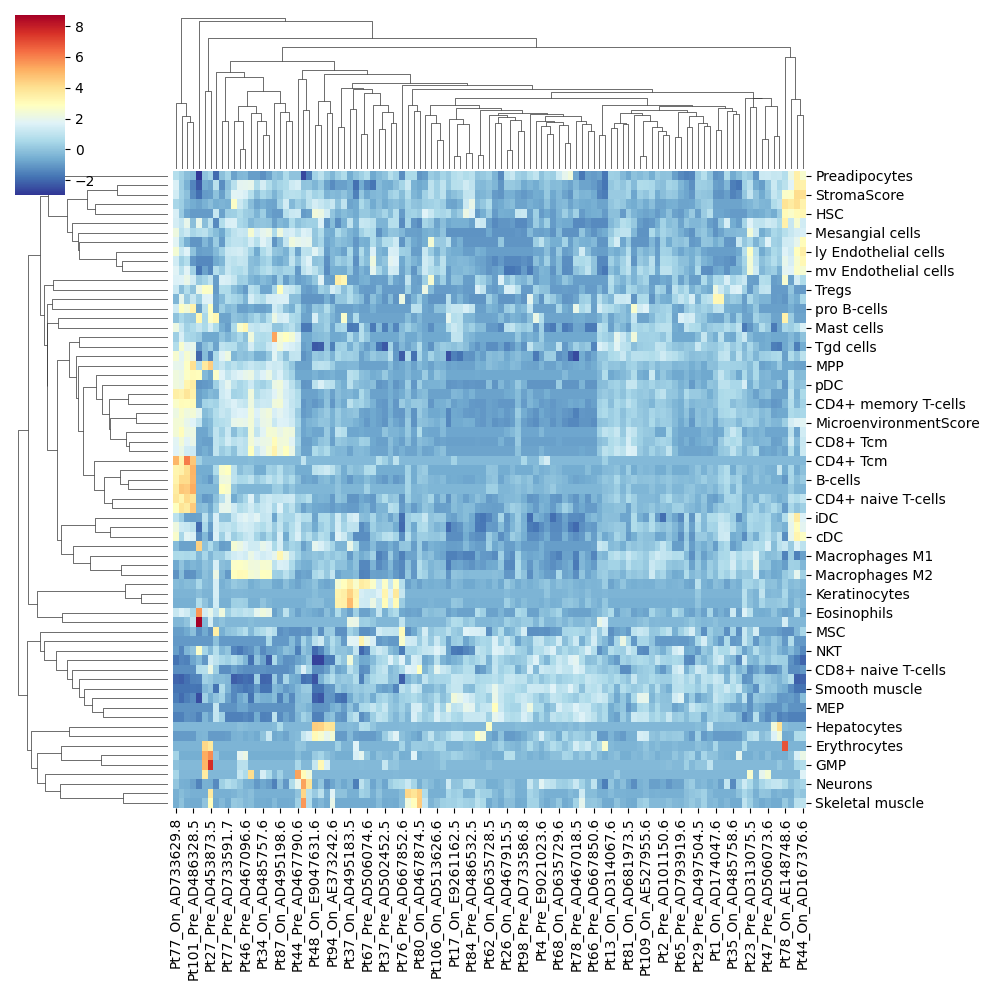

In [57]:
sns.clustermap(df_immuno_results,z_score=0,cmap='RdYlBu_r')
plt.show()

# 5.PHÂN TÍCH CHỨC NĂNG CỦA GENE (GENE ONTOLOGY)

**NHẬN XÉT:** Sử dụng dụng thư viện gseapy để phân tích chức năng của các upregulated và downregulated genes:
+ Biological processes (BP)
+ Mocular function (MF)
+ Cellular components (CC)

## 5.1.UP REGULATED GENES

In [26]:
# Dictionary gene id: gene symbol
dict_upregulated_genes=utils.gene_dict_id_symbol(list_upregulated_genes_id)
list_upregulated_genes_symbol=list(dict_upregulated_genes.values())
list_upregulated_genes_symbol

Input sequence provided is already in string format. No operation performed


['PLCE1-AS1',
 'DNM1P35',
 'HPN-AS1',
 'LINC01531',
 'KPLCE',
 'FAM83F',
 'RAB6C-AS1',
 'CYKILR',
 'LINC00930',
 'CDH4',
 'LOC100287036',
 'LINC02894',
 'CCDC179',
 'SH3PXD2A-AS1',
 'LINC01093',
 'LOC100506274',
 'LINC00648',
 'ZNF571-AS1',
 'LINC01606',
 'AP1M2',
 'CEP295NL',
 'DHRS2',
 'CORO2B',
 'CDSN',
 'CEACAM5',
 'AGR2',
 'SLCO1B1',
 'CSPG5',
 'RFPL2',
 'SLC17A3',
 'GJB6',
 'FTCD',
 'SPINK5',
 'CHAD',
 'KLK11',
 'AKR1C4',
 'IL1RAPL1',
 'LDB3',
 'SOX21',
 'PKP3',
 'WIF1',
 'KLK8',
 'SCRG1',
 'FAM83F',
 'TRIM9',
 'SLITRK1',
 'DDIT4L',
 'TENT5B',
 'CKM',
 'CKMT2',
 'OLIG1',
 'DCD',
 'OLFM3',
 'MUCL1',
 'PRAP1',
 'CLCNKA',
 'CLCNKB',
 'PNLIPRP3',
 'TMEM132D',
 'SLC24A4',
 'AGBL1',
 'PLA2G4E',
 'ACSM2A',
 'ADH1A',
 'ZG16B',
 'USH1G',
 'GGT6',
 'PLK5',
 'RPTN',
 'ADH4',
 'LRRC39',
 'GJB4',
 'ZNF648',
 'TEDDM1',
 'COL2A1',
 'KLF17',
 'FAM83C',
 'CNTNAP5',
 'ADH6',
 'COL11A2',
 'COL17A1',
 'TRIM71',
 'C5orf58',
 'CPB2',
 'UNC5D',
 'ISM1',
 'SPMIP5',
 'MUC15',
 'TTC36',
 'KRT80',
 'A2ML1'

In [27]:
'CLU' in list_upregulated_genes_symbol

False

In [28]:
list_upregulated_genes_symbol = [
    g for g in list_upregulated_genes_symbol
    if isinstance(g, str) and g.strip() != ''
]

In [29]:
# Phân tích GO 
enr_up=gseapy.enrichr(gene_list=list_upregulated_genes_symbol,
                      gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                      outdir=None,
                      background=None,
                      organism='human')

In [30]:
result_GO_up_gene=enr_up.results
result_GO_up_gene

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,epidermis development (GO:0008544),28/83,1.074805e-23,2.104469e-20,0,0,19.569253,1.034965e+03,COL17A1;SPRR2E;SPRR2G;CALML5;KLK5;EVPL;KLK7;CA...
1,GO_Biological_Process_2021,epidermal cell differentiation (GO:0009913),16/53,3.094702e-13,3.029713e-10,0,0,16.251764,4.681144e+02,CERS3;SPRR2G;CDSN;SPINK5;KRT10;OVOL1;EVPL;SCEL...
2,GO_Biological_Process_2021,keratinocyte differentiation (GO:0030216),14/41,1.400837e-12,9.142795e-10,0,0,19.421965,5.301022e+02,CERS3;SPRR2G;CDSN;KRT10;EVPL;SCEL;KRT16;LORICR...
3,GO_Biological_Process_2021,skin development (GO:0043588),18/80,2.661191e-12,1.302653e-09,0,0,10.939242,2.915554e+02,CERS3;SPRR2G;CDSN;KRT10;ABCA12;EVPL;ASPRV1;FLG...
4,GO_Biological_Process_2021,peptide cross-linking (GO:0018149),12/31,1.009974e-11,3.955057e-09,0,0,23.575715,5.969020e+02,SPRR2E;KRT2;KRT1;LORICRIN;PI3;KRT10;TGM5;EVPL;...
...,...,...,...,...,...,...,...,...,...,...
2573,GO_Molecular_Function_2021,ATP binding (GO:0005524),1/278,9.994774e-01,9.999949e-01,0,0,0.130222,6.806578e-05,ABCA12
2574,GO_Molecular_Function_2021,kinase binding (GO:0019900),3/461,9.996688e-01,9.999949e-01,0,0,0.234930,7.782216e-05,FAM83F;FAM83C;FAM83B
2575,GO_Molecular_Function_2021,adenyl ribonucleotide binding (GO:0032559),1/306,9.997558e-01,9.999949e-01,0,0,0.118094,2.884320e-05,ABCA12
2576,GO_Molecular_Function_2021,protein serine/threonine kinase activity (GO:0...,1/344,9.999119e-01,9.999949e-01,0,0,0.104803,9.236722e-06,STK32A


<Axes: title={'center': 'GO FOR UP-REGULATED GENES'}, xlabel='Gene_set'>

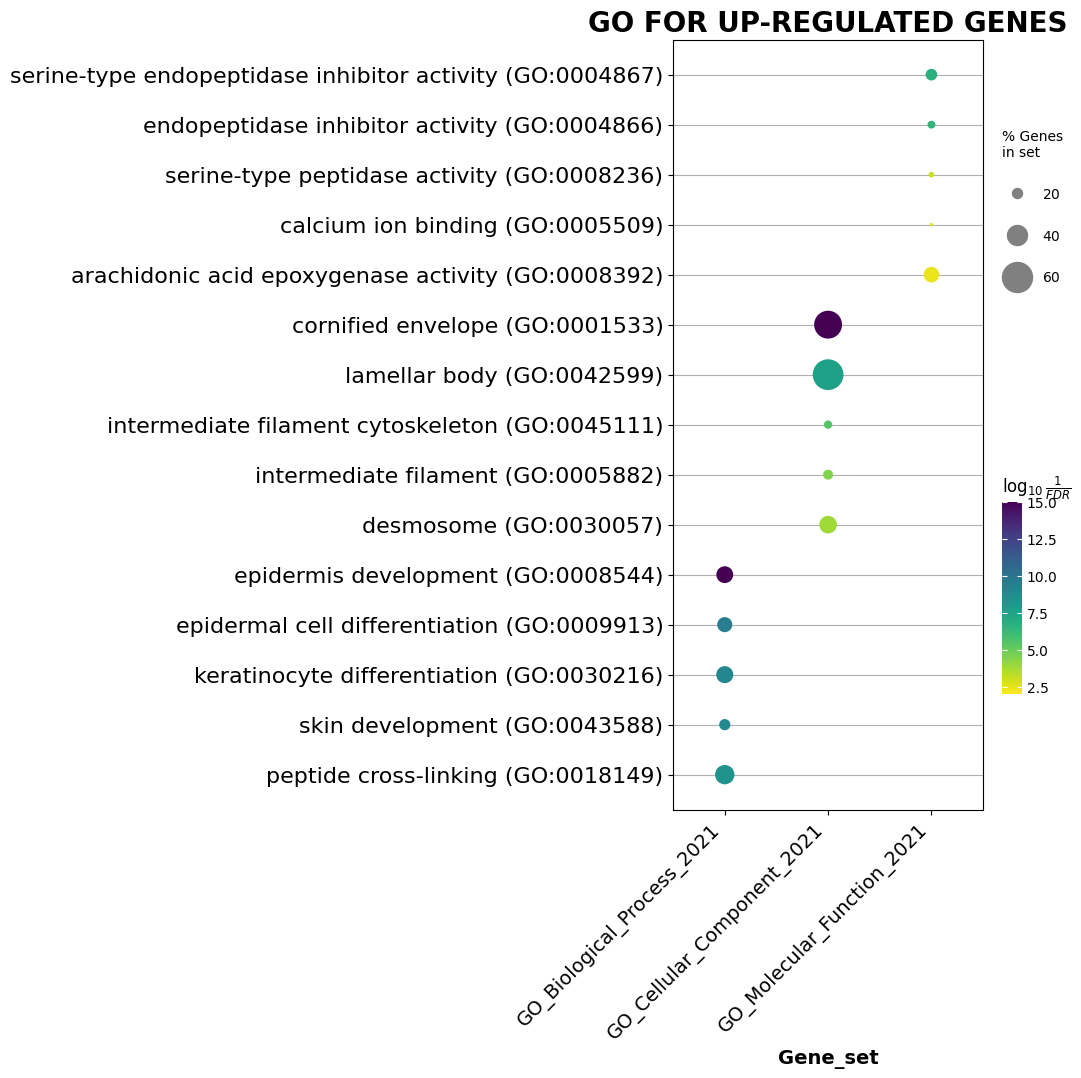

In [31]:
gseapy.dotplot(df=result_GO_up_gene,
               column='Adjusted P-value',
               size=6,
               top_term=5,
               figsize=(5,10),
               title='GO FOR UP-REGULATED GENES',
               cmap='viridis_r',
               x='Gene_set',
               xticklabels_rot=45)

## 5.2.DOWN REGUALATED GENES

In [32]:
# Dictionary gene id: gene symbol
dict_downregulated_genes=utils.gene_dict_id_symbol(list_downregulated_genes_id)
list_downregulated_genes_symbol=list(dict_downregulated_genes.values())
list_downregulated_genes_symbol

Input sequence provided is already in string format. No operation performed


['LINC00861',
 'MEF2B',
 'LINC00578',
 'LNROP',
 'LRCOL1',
 'APOC4-APOC2',
 'KIAA2012',
 'VAV3-AS1',
 'PRG4',
 'GPA33',
 'RASGRP2',
 'CLEC4M',
 'CDO1',
 'CEBPA',
 'CES1',
 'CETP',
 'GRAP',
 'ALDH1L1',
 'CFHR3',
 'SDS',
 'MAP4K1',
 'ANXA10',
 'SP140',
 'TUBA3E',
 'ACKR5',
 'CHRNA1',
 'GALNT13',
 'SLAMF6',
 'FCRL1',
 'FCRL3',
 'TNFRSF13C',
 'CLU',
 'TMEM52B',
 'GTSF1',
 'PLD4',
 'CCR6',
 'CCR7',
 'ANKRD26P1',
 'HSF5',
 'ADH1B',
 'TMIGD2',
 'CNR2',
 'TRABD2A',
 'ACMSD',
 'UROC1',
 'CR2',
 'ARID3C',
 'DBH-AS1',
 'CRHR1',
 'CRP',
 'CRYBB3',
 'PSMA8',
 'CSF3',
 'AMDHD1',
 'CARMIL2',
 'CAPN12',
 'ADRA1A',
 'TLCD4',
 'CFAP57',
 'KLB',
 'CYP3A5',
 'CYP7A1',
 'CYP8B1',
 'LINC00475',
 'DBH',
 'AKR1C1',
 'OXER1',
 'PARP15',
 'CHST13',
 'RASSF6',
 'IDO2',
 'OIT3',
 'SEPTIN1',
 'SARDH',
 'DNAH5',
 'DNAH8',
 'DNASE1L3',
 'AGT',
 'DTX1',
 'AGTR1',
 'EGFR',
 'LDHD',
 'NIBAN3',
 'ELK2AP',
 'ELN',
 'UICLM',
 'SLC16A13',
 'NRK',
 'F11',
 'F12',
 'ALDH2',
 'FBP1',
 'FCER2',
 'ADGRG5',
 'FCN2',
 'FGA',
 'FG

In [33]:
# Phân tích GO 
enr=gseapy.enrichr(gene_list=list_downregulated_genes_symbol,
                   gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                   outdir=None,
                   background=None,organism='human')

In [34]:
result_GO_down_gene=enr.results
result_GO_down_gene

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of humoral immune response (GO:0002...,14/54,6.892203e-13,1.363278e-09,0,0,19.315070,5.408841e+02,CR2;C1S;CFH;C1R;CFI;C4BPB;CLU;C3;C7;CFHR1;C9;C...
1,GO_Biological_Process_2021,regulation of complement activation (GO:0030449),13/50,4.455708e-12,4.406695e-09,0,0,19.338142,5.054378e+02,CR2;C1S;CFH;C1R;CFI;C4BPB;CLU;C3;C7;CFHR1;C9;C...
2,GO_Biological_Process_2021,regulation of immune effector process (GO:0002...,13/53,1.005017e-11,6.626412e-09,0,0,17.885042,4.529106e+02,CR2;C1S;CFH;C1R;CFI;C4BPB;CLU;C3;C7;CFHR1;C9;C...
3,GO_Biological_Process_2021,negative regulation of blood coagulation (GO:0...,9/40,3.709168e-08,1.834183e-05,0,0,15.806452,2.704464e+02,FGB;FGA;F12;F11;FGG;SERPING1;PLG;TFPI;KNG1
4,GO_Biological_Process_2021,regulation of B cell receptor signaling pathwa...,7/23,1.306681e-07,5.169228e-05,0,0,23.705974,3.757540e+02,BLK;FCRL3;CD19;STAP1;GCSAM;PAX5;CD22
...,...,...,...,...,...,...,...,...,...,...
2515,GO_Molecular_Function_2021,ubiquitin protein ligase activity (GO:0061630),1/263,9.927736e-01,9.999955e-01,0,0,0.200890,1.456989e-03,DTX1
2516,GO_Molecular_Function_2021,ubiquitin-like protein ligase activity (GO:006...,1/270,9.936677e-01,9.999955e-01,0,0,0.195592,1.242489e-03,DTX1
2517,GO_Molecular_Function_2021,cadherin binding (GO:0045296),1/322,9.976288e-01,9.999955e-01,0,0,0.163467,3.880689e-04,EGFR
2518,GO_Molecular_Function_2021,ubiquitin-protein transferase activity (GO:000...,1/392,9.993691e-01,9.999955e-01,0,0,0.133715,8.439152e-05,DTX1


<Axes: title={'center': 'GO FOR DOWN-REGULATED GENES'}, xlabel='Gene_set'>

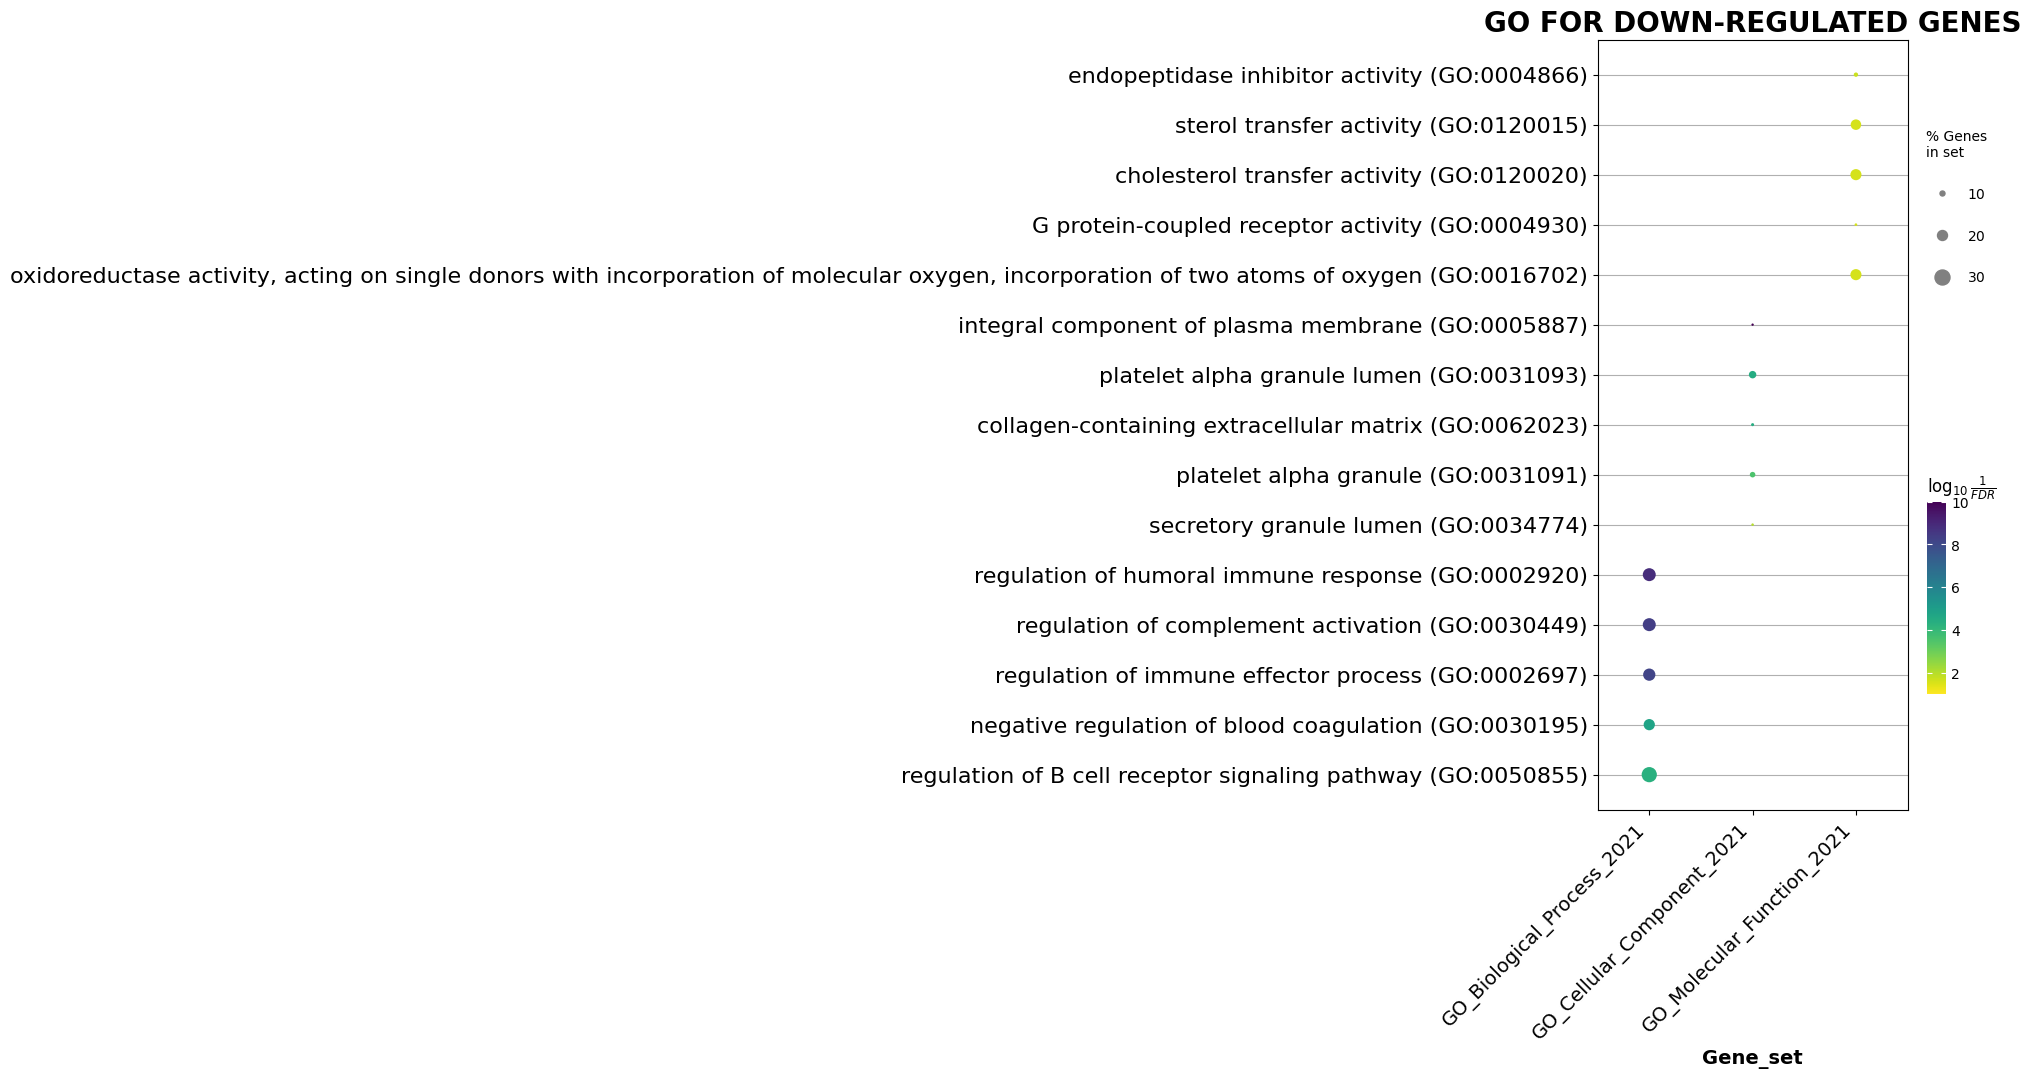

In [35]:
gseapy.dotplot(df=result_GO_down_gene,
               column='Adjusted P-value',
               size=6,
               top_term=5,
               figsize=(5,10),
               title='GO FOR DOWN-REGULATED GENES',
               cmap='viridis_r',
               x='Gene_set',
               xticklabels_rot=45)

# 6.SVM-RFE

**CHÚ TÍCH:** SỬ DỤNG MÔ HÌNH SVM-RFE ĐỂ XÁC ĐỊNH TOP 4 GENE QUÁ BIỂU HIỆN, TOP 4 GENE GIẢM BIỂU HIỆN VÀ TOP 100 GENE LIÊN QUAN ĐẾN ICI RESPONSE (FEATURE IMPORYANCES)

## 6.1.TRAIN SVM-RFE MODEL

In [59]:
def important_gene_by_SVM_RFE(list_genes:list,n_feature_importance:int,df_normalized_count:pd.DataFrame,df_meta:pd.DataFrame)->list:
    # CHUYỂN CÁC ITEMS TRONG LIST THÀNH DẠNG INTEGER:
    list_genes=list(map(str,list_genes))
    # INPUT
    X_train=df_normalized_count.loc[::,list_genes]
    # OUTPUT
    y_train=df_meta['New_conditions_encoded']
    # SELECT MODEL
    SCV_model=LinearSVC(random_state=42)
    rfe=RFE(estimator=SCV_model,n_features_to_select=n_feature_importance,step=1)
    # TRAIN MODEL
    rfe.fit(X=X_train,y=y_train)
    # SELECT IMPORT GENES
    selected_genes=X_train.columns[rfe.support_]
    return list(selected_genes)

In [60]:
# CHỌN TOP 4 UPREGULATED GENES
top_4_up_genes=important_gene_by_SVM_RFE(list_upregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [61]:
# CHỌN TOP 4 DOWNREGULATED GENES
top_4_down_genes=important_gene_by_SVM_RFE(list_downregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [62]:
# CHỌN TOP 100 gồm cả UPREGULATED VÀ DOWNREGULATED GENES
top_100_genes=important_gene_by_SVM_RFE(list_up_down_genes_id,100,df_gse91061_normalized,df_meta_GSE91061)

## 6.2.LƯU CÁC LIST GENES 

In [63]:
# Lưu 
def save(path,Object):
    with open(path,mode='wb') as f:
        pickle.dump(Object,f)
    print('Complete')

In [64]:
save('Top_genes_SVM_RFE/top_4_up_genes.pkl',top_4_up_genes)
save('Top_genes_SVM_RFE/top_4_down_genes.pkl',top_4_down_genes)
save('Top_genes_SVM_RFE/top_100_genes.pkl',top_100_genes)

Complete
Complete
Complete


## 6.3.ĐỌC CÁC LIST GENES

In [65]:
# Đoc file
def read(path):
    with open(path,mode='rb') as f:
        list_genes=pickle.load(f)
    return list_genes

In [66]:
top_4_up=read('Top_genes_SVM_RFE/top_4_up_genes.pkl')
top_4_down=read('Top_genes_SVM_RFE/top_4_down_genes.pkl')
top_100=read('Top_genes_SVM_RFE/top_100_genes.pkl')

## 6.4.KẾT QUẢ

In [67]:
dict_top_4_up=utils.gene_dict_id_symbol(top_4_up)
print(f'Top 4 genes upregulated bao gồm:\n{dict_top_4_up.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes upregulated bao gồm:
dict_values(['RPTN', 'FABP6', 'TRIM67', 'TMC5'])


In [68]:
dict_top_4_down=utils.gene_dict_id_symbol(top_4_down)
print(f'Top 4 genes downregulated bao gồm:\n{dict_top_4_down.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes downregulated bao gồm:
dict_values(['HTR6', 'BDKRB1', 'FCAMR', 'TNFSF11'])


In [69]:
dict_top_100=utils.gene_dict_id_symbol(top_100)
print(f'Top 100 genes bao gồm:\n{dict_top_100.values()}')

Input sequence provided is already in string format. No operation performed


Top 100 genes bao gồm:
dict_values(['PRG4', 'MAP4K1', 'CHRNA1', 'GALNT13', 'GTSF1', 'CSF3', 'DNAH8', 'NIBAN3', 'ELK2AP', 'ELN', 'FCER2', 'KCNH3', 'LILRA4', 'CLDN14', 'ALOX15B', 'GCSAM', 'ONECUT1', 'SERPINA9', 'FIBIN', 'SPDYC', 'SERTM2', 'MCF2', 'NELL2', 'ENPP1', 'PON1', 'SLC47A1', 'ARHGAP15', 'CLLU1', 'PPP4R4', 'TNFRSF17', 'BDKRB1', 'UGT2B17', 'VGF', 'TCL1A', 'GDF5', 'TNFSF11', 'CD5L', 'CD27', 'KPLCE', 'CCDC179', 'DHRS2', 'CHAD', 'OLIG1', 'SLC24A4', 'ZG16B', 'MUC15', 'TTC36', 'FRG2DP', 'DCC', 'DLX3', 'SDR16C5', 'ERBB4', 'FABP6', 'LINC03040', 'SLC16A8', 'SPESP1', 'COL6A5', 'SLC26A4-AS1', 'GSTA3', 'SLC39A2', 'HBG2', 'HTR2B', 'APOA2', 'IBSP', 'NIPAL4', 'ITIH2', 'VWC2', 'KCNK2', 'KRT6A', 'SLC6A10P', 'ZNF728', 'MC5R', 'MMP13', 'TRIM67', 'PTCHD4', 'IGFL4', 'SSUH2', 'PCSK2', 'SOX6', 'KLK10', 'PSG4', 'RAB25', 'PTPRN', 'RFX4', 'SCN1A', 'SLC9A3', 'ZNF812P', 'UCHL1', 'C1orf116', 'GALNT14', 'ZNF750', 'EPHX3', 'GRHL2', 'ST8SIA2', 'TKTL1', 'H4C8', 'SERPINB7', 'H2BC11', 'HSPB3', 'TDRD12'])


# 7.SURVIVAL-ASSOCIACITED DEGS

## 7.1.XÁC ĐỊNH GENE CÓ LIÊN QUAN ĐẾN KHẢ NĂNG SỐNG CÒN

**CHÚ THÍCH:**
+ Overlap top 100 gene xác định từ SVM-RFE và tập dữ liệu gene liên quan đến khả năng sống còn
+ Tập dữ liệu liên quan đến khả năng sống của bệnh nhân mắc bệnh ung thư da lấy từ: [gepia2]('http://gepia2.cancer-pku.cn/#survival')

In [27]:
# ĐỌC DỮ LIỆU SURVIVAL GENES
survival_genes=pd.read_csv('melanoma/TCGA/table_survival (1).txt',delimiter='\t')
survival_genes

,Gene Symbol,Gene ID,P-Value (Survival os)
0,EAF2,ENSG00000145088.8,1.870000e-09
1,RP11-693J15.5,ENSG00000205056.8,2.320000e-09
2,GBP2,ENSG00000162645.12,5.180000e-09
3,KLRD1,ENSG00000134539.16,8.150000e-09
4,PTBP1P,ENSG00000259078.2,9.920000e-09
...,...,...,...
495,MIAT,ENSG00000225783.6,5.430000e-05
496,CFB,ENSG00000243649.8,5.460000e-05
497,MAP3K7CL,ENSG00000156265.15,5.500000e-05
498,KCNMB1,ENSG00000145936.8,5.570000e-05


In [28]:
# LIST CÁC SURVIVAL GENES
list_survival_genes=survival_genes['Gene Symbol'].tolist()
list_survival_genes

['EAF2',
 'RP11-693J15.5',
 'GBP2',
 'KLRD1',
 'PTBP1P',
 'IDO1',
 'UBA7',
 'APOBEC3G',
 'ACSM3',
 'FAM105A',
 'CMAHP',
 'PTPN22',
 'RP1-28O10.1',
 'TIMD4',
 'CCL4',
 'SAMD9L',
 'GCNT1',
 'CA8',
 'TRAPPC3L',
 'RP11-212I21.5',
 'EVI2B',
 'PARP12',
 'KLRC1',
 'AC093818.1',
 'HSPA7',
 'GBP5',
 'CHRM3-AS2',
 'NCCRP1',
 'ADGRG5',
 'GCH1',
 'NT5DC2',
 'TMSB4X',
 'CD200R1',
 'SIGLEC10',
 'NLRP6',
 'HAPLN3',
 'GIMAP5',
 'GBP4',
 'KLRC2',
 'KIR2DL4',
 'IL12A',
 'PIPOX',
 'PARP15',
 'AC006129.2',
 'HMGB3P32',
 'PSMB9',
 'VNN2',
 'HLA-DPA1',
 'NPM1P25',
 'TNFSF13B',
 'IL2RA',
 'THEMIS',
 'AC009133.17',
 'SRGN',
 'PDCD1LG2',
 'DOCK2',
 'FCRL3',
 'EIF1B-AS1',
 'FGL2',
 'AC022182.3',
 'PLA2G2D',
 'C5orf56',
 'RARRES3',
 'RP11-10J5.1',
 'IRF1',
 'LINC00861',
 'TNFSF10',
 'TLR2',
 'KLRC4',
 'RP11-1399P15.1',
 'RP11-284N8.3',
 'LILRB1',
 'SPATC1',
 'BST2',
 'FCGR2C',
 'CD86',
 'KLHDC7B',
 'APOL6',
 'LAPTM5',
 'RP11-618M23.5',
 'RTN1',
 'CCL8',
 'SP140L',
 'LINC00528',
 'PKHD1L1',
 'CD72',
 'FAM26F',
 '

In [29]:
# OVERLAP SURVIVAL GENE VÀ TOP 100 GENES
top_8_genes=np.intersect1d(list_survival_genes,list(dict_top_100.values()))
top_8_genes

array(['CD8A', 'HSD11B1', 'ITGB2-AS1', 'NCCRP1', 'TIMD4', 'TNFRSF17',
       'TRAV13-2'], dtype='<U14')

## 7.2.TRAIN MÔ HÌNH COX REGRESSION (UNIVARIATE)

**CHÚ THÍCH:**
+ Sử dụng mô hình cox regression để xác định mức độ ảnh hưởng của các gene cùng với độ tuổi và giới tính lên sự sống còn
+ Danh sách các gene được fit vào mô hình được chọn bằng cách overlap top 100 gene và survival gene data set:`'CD8A', 'HSD11B1', 'ITGB2-AS1', 'NCCRP1', 'TIMD4', 'TNFRSF17', 'TRAV13-2'`
+ CÁC BIẾN ĐẦU VÀO SẼ ĐƯỢC XÁC ĐỊNH CUTOFF, NẰM TRONG KHOẢNG Q1 ĐẾN Q3 CỦA DỮ LIỆU MỖI BIẾN VÀ SAO CHO P-VALUE ĐẠT GIÁ TRỊ NHỎ NHẤT

In [30]:
# ĐỌC FILE TỪ BỘ SKCM_DFCI_2015
df_skcm_dfci_2015=utils.precocessing_dataset_from_cBioPortal(name='skcm_dfci_2015',list_selected_genes=top_8_genes)
## ĐỌC FILE TỪ BỘ SKCM_MSKCC_2014
df_skcm_mskcc_2014=utils.precocessing_dataset_from_cBioPortal(name='skcm_mskcc_2014',list_selected_genes=top_8_genes)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [31]:
# KẾT HỢP 2 BỘ DATA
df_combined=pd.concat([df_skcm_dfci_2015,df_skcm_mskcc_2014],axis=0)
df_combined

,OS_MONTHS,AGE,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,TNFRSF17,TIMD4,CD8A,OS_STATUS_ENCODED,SEX_ENCODED
Pat02,54.400000,42,0.014737,0.000000,3.313033,0.000000,0.189413,2.263617,9.983776,0,0
Pat03,3.333333,61,0.000000,0.217425,2.390844,22.545881,0.704331,1.118194,1.096203,1,0
Pat04,32.900000,71,0.000000,0.000000,4.838899,0.000000,0.060789,0.378058,7.419709,0,1
Pat06,5.366667,33,0.032093,1.437272,9.260183,0.415545,2.818761,3.705645,19.559241,1,1
Pat08,4.666667,73,0.000000,0.370982,6.271693,0.121145,1.671455,0.682584,9.530435,1,1
...,...,...,...,...,...,...,...,...,...,...,...
SD5038,13.972600,55,0.094911,0.123204,1.209619,0.025602,1.039191,0.297528,2.406724,1,1
SD5118,32.843840,55,2.653418,2.833927,4.996877,0.228351,7.508236,4.190028,14.512821,1,0
SD6336,83.375340,53,0.889496,1.118118,3.185682,0.218683,0.072361,1.041241,30.666627,0,1
SD6494,8.712329,63,0.071487,0.000000,0.273325,1.764461,0.000000,0.018675,0.186453,1,0


In [32]:
data=[]
for col in df_combined.drop(columns=['OS_STATUS_ENCODED','OS_MONTHS']).columns:
    if col !='SEX_ENCODED':
        p,cutoff,HR,HR_lower,HR_upper=utils.cox_regression_model_univariate(df_combined,col,100)
    else:
        p,HR,HR_lower,HR_upper=utils.cox_regression_model(df_combined,'SEX_ENCODED')
    data.append({
        'variable': col,
        'p':p,
        'HR (95% CI)': f'{HR} ({HR_lower}-{HR_upper})'
    })

## 7.3.KẾT QUẢ

In [33]:
df_result_survival_analysis=pd.DataFrame(data)
df_result_survival_analysis

,variable,p,HR (95% CI)
0,AGE,0.457676,0.77 (0.38-1.54)
1,ITGB2-AS1,0.005570,0.41 (0.22-0.77)
2,TRAV13-2,0.000133,0.27 (0.14-0.53)
3,HSD11B1,0.001583,0.26 (0.12-0.6)
4,NCCRP1,0.015775,0.44 (0.23-0.86)
5,TNFRSF17,0.103150,0.51 (0.22-1.15)
6,TIMD4,0.000495,0.31 (0.16-0.6)
7,CD8A,0.000762,0.32 (0.17-0.62)
8,SEX_ENCODED,0.059853,0.55 (0.29-1.03)


# 8.RANDOMFOREST-CLASSIFIER

## 8.1.RFC-SURV

#### 8.1.1.CHUẨN BỊ DỮ LIỆU 

In [34]:
dict_top_8_gene=utils.gene_dict_id_symbol(top_8_genes)
dict_top_8_gene

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


{'925': 'CD8A',
 '3290': 'HSD11B1',
 '100505746': 'ITGB2-AS1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [41]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_surv=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_top_8_gene.values())]
df_gse78220_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425
Pt15.baseline,10.995700,0.508158,1.823070,0.163296,0.290699,1.527530
Pt16.OnTx,2.647070,1.764710,0.322519,1.634550,0.000000,0.217395
Pt19.baseline,9.030915,0.988278,0.506889,0.150637,0.249476,0.547161
Pt2.baseline,9.691270,164.842000,0.818914,0.067927,5.431415,0.128545
Pt20.baseline,109.778500,9.045125,4.971495,0.765850,0.357466,37.044300


In [43]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_surv=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_top_8_gene.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_surv.rename(columns=dict_top_8_gene,inplace=True)
df_gse91061_normalized_rfc_surv

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,TNFRSF17,TIMD4,CD8A
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,8.603622,9.656047,11.377792
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,8.769242,9.747960,11.328933
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,3.483469,2.726851,7.635343
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.163234,4.823249,10.936760
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,5.968032,6.871137,11.907791
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,5.946053,7.004949,9.424188
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,4.448721,4.483002,10.164901
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,4.122981,2.383578,7.526615
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,1.715957,3.383643,8.367420


In [44]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_surv=pd.concat([df_gse78220_rfc_surv,df_gse91061_normalized_rfc_surv],axis=0)
X_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935,NaN
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000,NaN
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566,NaN
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212,NaN
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425,NaN
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,7.519322,6.292089,4.302166,7.004949,5.946053,3.587451
Pt98_On_AE086717-6,10.164901,7.568341,5.643992,6.066942,4.483002,4.448721,4.476089
Pt98_Pre_AD733586-8,7.526615,6.396133,4.690230,5.924993,2.383578,4.122981,1.731532
Pt9_On_E9047644-7,8.367420,4.710765,4.860693,3.461268,3.383643,1.715957,1.255144


In [45]:
y_rfc_surv=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_surv

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [48]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_surv,X_test_rfc_surv,y_train_rfc_surv,y_test_rfc_surv=train_test_split(X_rfc_surv,
                                                                                   y_rfc_surv,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_surv)

#### 8.1.2.TRAIN MÔ HÌNH

In [50]:
# CROSS-VALIDATION
cross_validation_rfc_surv=utils.cross_validation_by_RFC(10,X_train_rfc_surv,y_train_rfc_surv,'accuracy',42)
cross_validation_rfc_surv

array([0.63636364, 0.90909091, 0.72727273, 0.54545455, 0.90909091,
       0.54545455, 0.7       , 0.9       , 0.5       , 0.6       ])

In [56]:
# TRAIN MÔ HÌNH RFC_SURV (LẬP 100 LẦN)
df_score_rfc_surv,df_feature_rfc_surv=utils.training_RFC(X_train_rfc_surv,
                                                         y_train_rfc_surv,
                                                         X_test_rfc_surv,
                                                         y_test_rfc_surv,100)

In [57]:
# METRICS CỦA RFC_SURV
df_score_rfc_surv

,accuracy_test,accuracy_train,recall,precison,f1
0,0.703704,1.0,0.85,0.772727,0.809524
1,0.777778,1.0,0.90,0.818182,0.857143
2,0.740741,1.0,0.85,0.809524,0.829268
3,0.851852,1.0,0.90,0.900000,0.900000
4,0.814815,1.0,0.90,0.857143,0.878049
...,...,...,...,...,...
95,0.777778,1.0,0.90,0.818182,0.857143
96,0.740741,1.0,0.90,0.782609,0.837209
97,0.814815,1.0,0.90,0.857143,0.878049
98,0.851852,1.0,0.90,0.900000,0.900000


In [58]:
# FEATURE IMPORTANCE
df_feature_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
0,0.155663,0.161585,0.118979,0.142402,0.136191,0.124167,0.161013
1,0.150076,0.140578,0.118760,0.125545,0.171036,0.143915,0.150090
2,0.121774,0.147134,0.128135,0.151343,0.156760,0.137096,0.157758
3,0.132975,0.143923,0.111263,0.163761,0.155314,0.124239,0.168524
4,0.138004,0.142592,0.122591,0.142582,0.168666,0.125671,0.159895
...,...,...,...,...,...,...,...
95,0.143560,0.144840,0.120210,0.150137,0.152975,0.133871,0.154407
96,0.162710,0.134448,0.119839,0.144614,0.162728,0.128893,0.146769
97,0.145335,0.126817,0.124624,0.138279,0.174144,0.144077,0.146722
98,0.130338,0.122305,0.128286,0.134922,0.163126,0.143673,0.177351


#### 8.1.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [53]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_surv.mean():.4f}±{cross_validation_rfc_surv.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.6973±0.1516


In [60]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_surv_final=utils.caculate_result(df_score_rfc_surv)
df_score_rfc_surv_final

,mean,std
accuracy_test,0.780370,0.035020
accuracy_train,1.000000,0.000000
recall,0.889500,0.020468
precison,0.828034,0.031216
f1,0.857349,0.021337


In [73]:
#BẢN KẾT QUẢ FEATURE IMPORTANCE
df_feature_rfc_surv_final=utils.caculate_result(df_feature_rfc_surv)
df_feature_rfc_surv_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_surv_final

,mean,std
ITGB2-AS1,0.121842,0.008013
TNFRSF17,0.133090,0.010667
HSD11B1,0.139998,0.008808
NCCRP1,0.140186,0.010898
CD8A,0.150170,0.011666
TRAV13-2,0.154704,0.010015
TIMD4,0.160010,0.012092


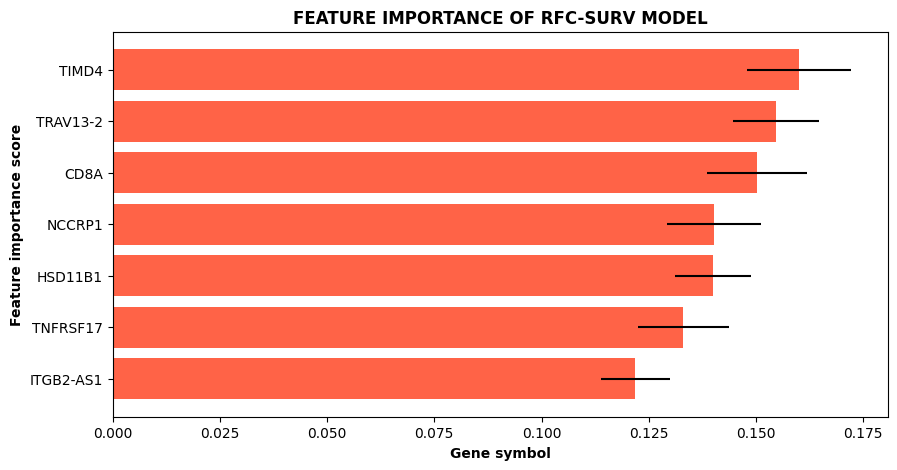

In [100]:
# TRỰC QUAN HÓA KẾT QUẢ FEATURE IMPORTANCE
utils.feature_importance_graph(df_feature_rfc_surv_final,'FEATURE IMPORTANCE OF RFC-SURV MODEL')

## 8.2.RFC-SEQ

In [20]:
def gene_filtered_dataframe(df:pd.DataFrame,dict_seleceted_gene:dict)->pd.DataFrame:
    list_gene_in_df=df.columns
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE ID: DIGIT
    if all(list(map(lambda x:x.isdigit(),list_gene_in_df))):
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.keys())]
        df.rename(columns=dict_seleceted_gene,inplace=True)
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE SYMBOL
    else:
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.values())]
    return df

#### 8.2.1.CHUẨN BỊ DỮ LIỆU 

In [103]:
dict_up_and_down_genes=utils.gene_dict_id_symbol(top_4_down+top_4_up)
dict_up_and_down_genes

Input sequence provided is already in string format. No operation performed


{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3'}

In [104]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_seq=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_up_and_down_genes.values())]
df_gse78220_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03
Pt15.baseline,0.017010,2.058855,0.790077,1.823070,0.000000,4.330925,2.776550e-01
Pt16.OnTx,0.041516,0.000000,0.000000,0.322519,0.000000,7.717720,2.386900e-31
Pt19.baseline,0.121219,5.411515,0.119415,0.506889,0.000000,8.108240,1.794970e-23
Pt2.baseline,0.000000,0.046564,0.668588,0.818914,0.000000,4.809975,7.592816e-23
Pt20.baseline,0.012530,0.050482,0.000000,4.971495,0.000000,25.811550,1.233295e+00


In [105]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_seq=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_up_and_down_genes.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_seq.rename(columns=dict_up_and_down_genes,inplace=True)
df_gse91061_normalized_rfc_seq

,ITGB2-AS1,LCE1C,IGFL4,PCDHA2,CLLU1,NCF1C,HSPB3,TAAR3P
Pt101_On_AD681975-5,9.725053,-1.444638,1.902541,1.035786,8.419779,10.030411,0.215859,-0.719818
Pt101_Pre_AD486328-5,9.244326,-1.311949,0.330398,1.063072,8.789311,11.536380,0.252421,-0.705124
Pt103_On_AE134059-6,5.532511,9.028036,2.373624,1.872334,3.617541,7.022998,1.854873,0.272620
Pt103_Pre_AE134058-2,9.005670,8.767246,0.496285,3.924143,5.441278,9.749929,4.172758,-0.649201
Pt105_On_AE373241-6,6.210693,-1.319089,0.327733,1.061530,4.096715,7.711705,0.250375,7.653572
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,-1.117803,0.406390,1.108352,4.282924,7.255980,0.311374,-0.680844
Pt98_On_AE086717-6,5.643992,-1.256759,0.351318,4.907566,0.911832,7.659717,3.884349,-0.698559
Pt98_Pre_AD733586-8,4.690230,-1.215408,0.367352,4.594762,2.298259,7.143329,4.772450,-0.693464
Pt9_On_E9047644-7,4.860693,-1.420400,3.452616,4.996088,2.776997,7.029241,8.120946,-0.717248


In [106]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_seq=pd.concat([df_gse78220_rfc_seq,df_gse91061_normalized_rfc_seq],axis=0)
X_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02,NaN
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02,NaN
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44,NaN
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02,NaN
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03,NaN
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.282924,0.311374,0.406390,6.292089,-1.117803,7.255980,1.108352e+00,-0.680844
Pt98_On_AE086717-6,0.911832,3.884349,0.351318,5.643992,-1.256759,7.659717,4.907566e+00,-0.698559
Pt98_Pre_AD733586-8,2.298259,4.772450,0.367352,4.690230,-1.215408,7.143329,4.594762e+00,-0.693464
Pt9_On_E9047644-7,2.776997,8.120946,3.452616,4.860693,-1.420400,7.029241,4.996088e+00,-0.717248


In [107]:
y_rfc_seq=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_seq

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [108]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_seq,X_test_rfc_seq,y_train_rfc_seq,y_test_rfc_seq=train_test_split(X_rfc_seq,
                                                                                   y_rfc_seq,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_seq)

#### 8.2.2.TRAIN MÔ HÌNH

In [111]:
# CROSS VADIATION MÔ HÌNH RFC-SEQ
cross_validation_rfc_seq=utils.cross_validation_by_RFC(10,X_train_rfc_seq,y_train_rfc_seq,'accuracy',42)
cross_validation_rfc_seq

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.7       , 0.7       ])

In [113]:
df_score_rfc_seq,df_feature_rfc_seq=utils.training_RFC(X_train_rfc_seq,y_train_rfc_seq,X_test_rfc_seq,y_test_rfc_seq,100)

In [118]:
# METRICS MÔ HÌNH RFC-SEQ
df_score_rfc_seq

,accuracy_test,accuracy_train,recall,precison,f1
0,0.814815,1.0,0.80,0.941176,0.864865
1,0.851852,1.0,0.85,0.944444,0.894737
2,0.814815,1.0,0.80,0.941176,0.864865
3,0.777778,1.0,0.75,0.937500,0.833333
4,0.851852,1.0,0.85,0.944444,0.894737
...,...,...,...,...,...
95,0.777778,1.0,0.75,0.937500,0.833333
96,0.814815,1.0,0.80,0.941176,0.864865
97,0.777778,1.0,0.80,0.888889,0.842105
98,0.814815,1.0,0.80,0.941176,0.864865


In [117]:
# FEATURE IMPORTANCE MÔ HÌNH RFC-SEQ
df_feature_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
0,0.145532,0.093876,0.132891,0.095737,0.074022,0.121048,0.161787,0.175107
1,0.140310,0.096364,0.131632,0.103649,0.076789,0.142005,0.135102,0.174148
2,0.162963,0.104152,0.142132,0.085788,0.089513,0.116643,0.132880,0.165930
3,0.153363,0.111564,0.110478,0.093375,0.077516,0.143254,0.149109,0.161343
4,0.140665,0.099508,0.111595,0.088690,0.092815,0.152322,0.155602,0.158803
...,...,...,...,...,...,...,...,...
95,0.160628,0.097245,0.115773,0.090919,0.083513,0.129900,0.164076,0.157945
96,0.181472,0.090150,0.125091,0.106112,0.071430,0.130089,0.157674,0.137983
97,0.160809,0.095875,0.131100,0.093716,0.075742,0.120778,0.155069,0.166910
98,0.137525,0.090300,0.119263,0.093658,0.082336,0.143080,0.172452,0.161386


#### 8.2.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [151]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_seq.mean():.4f}±{cross_validation_rfc_seq.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7645±0.0850


In [124]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_seq_final=utils.caculate_result(df_score_rfc_seq)
df_score_rfc_seq_final

,mean,std
accuracy_test,0.820370,0.035849
accuracy_train,1.000000,0.000000
recall,0.820500,0.044435
precison,0.929291,0.024148
f1,0.870758,0.027815


In [127]:
#BẢN KẾT QUẢ FEATURE IMPORANTANCE
df_feature_rfc_seq_final=utils.caculate_result(df_feature_rfc_seq)
df_feature_rfc_seq_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_seq_final

,mean,std
LCE1C,0.079113,0.006955
ITGB2-AS1,0.100751,0.008133
HSPB3,0.101770,0.008578
IGFL4,0.117374,0.009809
NCF1C,0.134043,0.010428
PCDHA2,0.152295,0.010845
TAAR3P,0.156363,0.010803
CLLU1,0.158292,0.010291


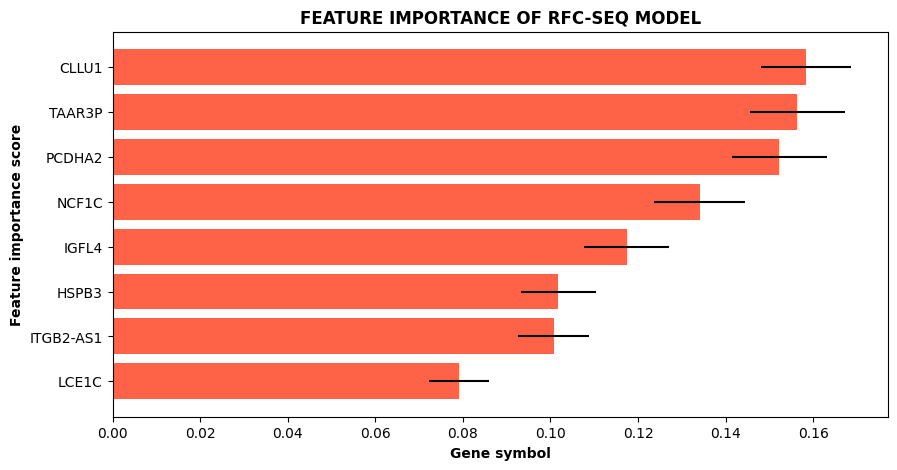

In [128]:
utils.feature_importance_graph(df_feature_rfc_seq_final,'FEATURE IMPORTANCE OF RFC-SEQ MODEL')

## 8.3.RFC-16

#### 8.3.1.CHUẨN BỊ DỮ LIỆU 

In [131]:
dict_gene_16=dict_up_and_down_genes.copy()
dict_gene_16.update(dict_top_8_gene)
dict_gene_16

{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3',
 '925': 'CD8A',
 '3290': 'HSD11B1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [133]:
df_gse78220_rfc_16=utils.gene_filtered_dataframe(df_gse78220_normalized,dict_gene_16)
df_gse78220_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425
Pt15.baseline,10.995700,0.017010,0.508158,2.058855,0.790077,1.823070,0.000000,0.163296,4.330925,2.776550e-01,0.290699,1.527530
Pt16.OnTx,2.647070,0.041516,1.764710,0.000000,0.000000,0.322519,0.000000,1.634550,7.717720,2.386900e-31,0.000000,0.217395
Pt19.baseline,9.030915,0.121219,0.988278,5.411515,0.119415,0.506889,0.000000,0.150637,8.108240,1.794970e-23,0.249476,0.547161
Pt2.baseline,9.691270,0.000000,164.842000,0.046564,0.668588,0.818914,0.000000,0.067927,4.809975,7.592816e-23,5.431415,0.128545
Pt20.baseline,109.778500,0.012530,9.045125,0.050482,0.000000,4.971495,0.000000,0.765850,25.811550,1.233295e+00,0.357466,37.044300


In [134]:
df_gse91061_normalized_rfc_16=utils.gene_filtered_dataframe(df_gse91061_normalized,dict_gene_16)
df_gse91061_normalized_rfc_16

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,LCE1C,IGFL4,PCDHA2,CLLU1,TNFRSF17,NCF1C,HSPB3,TIMD4,CD8A,TAAR3P
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,-1.444638,1.902541,1.035786,8.419779,8.603622,10.030411,0.215859,9.656047,11.377792,-0.719818
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,-1.311949,0.330398,1.063072,8.789311,8.769242,11.536380,0.252421,9.747960,11.328933,-0.705124
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,9.028036,2.373624,1.872334,3.617541,3.483469,7.022998,1.854873,2.726851,7.635343,0.272620
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.767246,0.496285,3.924143,5.441278,8.163234,9.749929,4.172758,4.823249,10.936760,-0.649201
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,-1.319089,0.327733,1.061530,4.096715,5.968032,7.711705,0.250375,6.871137,11.907791,7.653572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,-1.117803,0.406390,1.108352,4.282924,5.946053,7.255980,0.311374,7.004949,9.424188,-0.680844
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,-1.256759,0.351318,4.907566,0.911832,4.448721,7.659717,3.884349,4.483002,10.164901,-0.698559
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,-1.215408,0.367352,4.594762,2.298259,4.122981,7.143329,4.772450,2.383578,7.526615,-0.693464
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,-1.420400,3.452616,4.996088,2.776997,1.715957,7.029241,8.120946,3.383643,8.367420,-0.717248


In [136]:
X_rfc_16=pd.concat([df_gse78220_rfc_16,df_gse91061_normalized_rfc_16])
X_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17,TRAV13-2,TAAR3P
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935,NaN,NaN
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000,NaN,NaN
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566,NaN,NaN
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212,NaN,NaN
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,4.282924,7.519322,0.311374,0.406390,6.292089,-1.117803,4.302166,7.255980,1.108352e+00,7.004949,5.946053,3.587451,-0.680844
Pt98_On_AE086717-6,10.164901,0.911832,7.568341,3.884349,0.351318,5.643992,-1.256759,6.066942,7.659717,4.907566e+00,4.483002,4.448721,4.476089,-0.698559
Pt98_Pre_AD733586-8,7.526615,2.298259,6.396133,4.772450,0.367352,4.690230,-1.215408,5.924993,7.143329,4.594762e+00,2.383578,4.122981,1.731532,-0.693464
Pt9_On_E9047644-7,8.367420,2.776997,4.710765,8.120946,3.452616,4.860693,-1.420400,3.461268,7.029241,4.996088e+00,3.383643,1.715957,1.255144,-0.717248


In [139]:
y_rfc_16=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_16

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [141]:
X_train_rfc_16,X_test_rfc_16,y_train_rfc_16,y_test_rfc_16=train_test_split(X_rfc_16,
                                                                           y_rfc_16,
                                                                           random_state=42,
                                                                           stratify=y_rfc_16,
                                                                           train_size=0.8)

#### 8.3.2.TRAIN MÔ HÌNH

In [143]:
cross_validation_rfc_16=utils.cross_validation_by_RFC(10,X_train_rfc_16,y_train_rfc_16,'accuracy',seed=42)
cross_validation_rfc_16

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.5       , 0.6       ])

In [144]:
df_score_rfc_16,df_feature_rfc_16=utils.training_RFC(X_train_rfc_16,y_train_rfc_16,X_test_rfc_16,y_test_rfc_16,100)

#### 8.3.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [150]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_16.mean():.4f}±{cross_validation_rfc_16.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7345±0.1233


In [146]:
df_score_rfc_16_final=utils.caculate_result(df_score_rfc_16)
df_score_rfc_16_final

,mean,std
accuracy_test,0.842593,0.022566
accuracy_train,1.000000,0.000000
recall,0.840000,0.024618
precison,0.941244,0.013615
f1,0.887573,0.016936


In [148]:
df_feature_rfc_16_final=utils.caculate_result(df_feature_rfc_16)
df_feature_rfc_16_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_16_final

,mean,std
LCE1C,0.037461,0.005263
ITGB2-AS1,0.053929,0.006831
HSPB3,0.058328,0.006826
IGFL4,0.064565,0.007617
NCCRP1,0.064848,0.007410
TNFRSF17,0.064937,0.007459
NCF1C,0.068429,0.007404
CD8A,0.072012,0.008889
HSD11B1,0.072301,0.007276
TRAV13-2,0.079279,0.008861


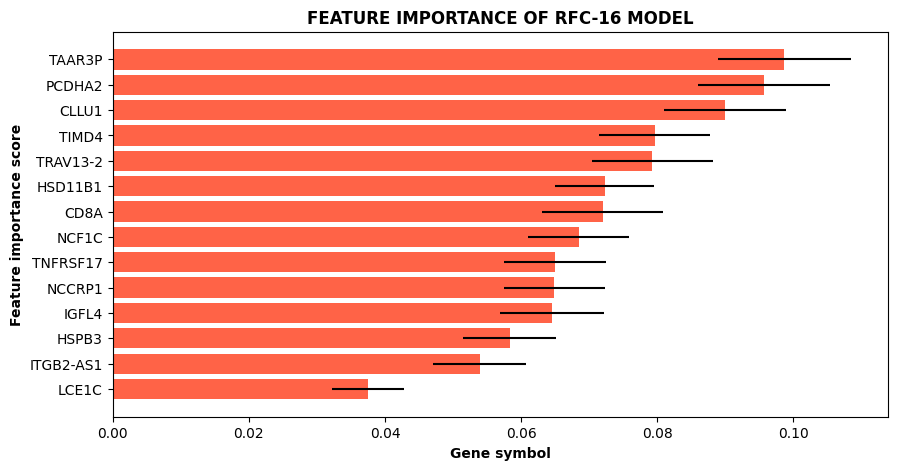

In [149]:
utils.feature_importance_graph(df_feature_rfc_16_final,'FEATURE IMPORTANCE OF RFC-16 MODEL')